<a href="https://colab.research.google.com/github/kiru883/Kaggle-IEEE-CIS-Fraud-Detection/blob/master/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
####  https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
####  https://www.kaggle.com/artgor/eda-and-models
####  https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
####  https://www.kaggle.com/alijs1/ieee-transaction-columns-reference
####  https://www.kaggle.com/c/ieee-fraud-detection/discussion/111321

In [28]:
from google.colab import drive, files
drive.mount('/content/gdrive')

import warnings
warnings.filterwarnings("ignore")

import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load datasets

In [0]:
#####LOAD DATASETS
# train
data_trainTR = pd.read_csv("/content/gdrive/My Drive/frauds_datasets/train_transaction.csv")
data_trainID = pd.read_csv("/content/gdrive/My Drive/frauds_datasets/train_identity.csv")
data_trainID = pd.concat([data_trainTR['TransactionID'].rename(data_trainTR['TransactionID'], axis='index'),
                          data_trainID.rename(data_trainID['TransactionID'], axis='index')], axis=1).reset_index(drop=True)
# test
data_testTR = pd.read_csv("/content/gdrive/My Drive/frauds_datasets/test_transaction.csv")
data_testID = pd.read_csv("/content/gdrive/My Drive/frauds_datasets/test_identity.csv")
data_testID = pd.concat([data_testTR['TransactionID'].rename(data_testTR['TransactionID'], axis='index'),
                          data_testID.rename(data_testID['TransactionID'], axis='index')], axis=1).reset_index(drop=True)                          

# Functions

In [0]:
def top_values_hist(x, data, ax, top_values_number=2, fraud_mode=True):
  nan_number = str(np.around(data[x].isnull().sum() / data[x].shape[0], 5))
  ax.set_title(x + " | " + nan_number + "% NaN's")
  labels = list(data[x].dropna().value_counts().index[:top_values_number])
  sns.countplot(x=x, data=data, order=sorted(labels),  ax=ax)
                 
  if fraud_mode:
    vcf = data[data['isFraud'] == 1][x].value_counts()
    vcf = vcf.reindex(vcf.index.astype(str))
    order = [x.get_text() for x in list(ax.get_xticklabels())]
    fraudx = [(ax.get_ylim()[1] * vcf[x])/vcf.sum() if x in list(vcf.index) else 0 
             for x in order]
    ax.plot(order, fraudx, label="fraud %")
    ax.tick_params(axis='x', rotation=60)
    ax.legend()
    
def improved_distplot(x, data, ax, bins_number=30):
  nan_number = str(np.around(data[x].isnull().sum() / data[x].shape[0], 5))
  ax.set_title(x + " | " + nan_number + "% NaN's")
  sns.distplot(data[data['isFraud']==1][x].dropna(), ax=ax, label='isFraud', color='black')
  sns.distplot(data[x].dropna(), ax=ax, color='green', bins=bins_number)
  ax.legend()
    
def frauds_contains_in_nans(x, data):
  fraud_in_nans = np.around(data[data['isFraud'] == 1][x].isnull().sum() /
                            data[data['isFraud'] == 1].shape[0], 5)
  print(f"{x} : {fraud_in_nans}% nan's contain fraud")
                             
def cat_hist(x, data, ax):
  nan_number = str(np.around(data[x].isnull().sum() / data[x].shape[0], 5))
  ax.set_title(x  + " | " + nan_number + "% NaN's")
  vcf = data[data['isFraud'] == 1][x].value_counts()
  sns.countplot(x=x, data=data, ax=ax)
  order = [x.get_text() for x in list(ax.get_xticklabels()) if x.get_text() in vcf.index]
  fraudx = [(ax.get_ylim()[1] * vcf[x])/vcf.sum() for x in order]
  ax.plot(order, fraudx, label="fraud %")
  ax.tick_params(axis='x', rotation=60)
  ax.legend()
    
def write_quantiles(x, data, quantiles):
  print(f'{x} quantiles: ', list(data[x].quantile(quantiles)))

def covariate_shift(train, test):
  df_train = pd.DataFrame(data={'feature': train, 'isTest': 0})
  df_test = pd.DataFrame(data={'feature': test, 'isTest': 1})
  # Creating a single dataframe
  df = pd.concat([df_train, df_test], ignore_index=True)
    
  # Encoding if feature is categorical
  if str(df['feature'].dtype) in ['object', 'category']:
      df['feature'] = LabelEncoder().fit_transform(df['feature'].astype(str))
    
  # Splitting it to a training and testing set
  X_train, X_test, y_train, y_test = train_test_split(df['feature'], df['isTest'], test_size=0.33, random_state=47, 
                                                      stratify=df['isTest'])

  clf = lgb.LGBMClassifier(num_boost_round=500)
  clf.fit(X_train.values.reshape(-1, 1), y_train)
  roc_auc =  roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1])

  del df, X_train, y_train, X_test, y_test
  gc.collect()
    
  return roc_auc

def timeseries_score(X, y):
  N_SPLITS = 3
  tss = TimeSeriesSplit(n_splits=N_SPLITS)
  score = 0

  for train_ind, test_ind in tss.split(X):
    X_train, X_test = X[train_ind], X[test_ind]
    y_train, y_test = y[train_ind], y[test_ind]

    clf = lgb.LGBMClassifier(num_boost_round=500)
    clf.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))
    score += roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1])

    del X_train, X_test, y_train, y_test
    gc.collect()

  return score / N_SPLITS

def rocauc_score(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X.values.reshape(-1, 1), y.values.reshape(-1, 1), test_size=0.33,
                                                      random_state=47)

  clf = lgb.LGBMClassifier(num_boost_round=500)
  clf.fit(X_train, y_train)
  score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

  del X_train, X_test, y_train, y_test
  gc.collect()

  return score

def get_info(train_X, test_X, y, info_df):
    info_df = info_df.append(pd.DataFrame({"feature": [train_X.name]*3,
                              "type": ["covariate", "timeseries", "rocauc"],
                              "scores": [covariate_shift(train_X, test_X), 
                                         timeseries_score(train_X, y), 
                                         rocauc_score(train_X, y)]}),
                             ignore_index=True)
    return info_df

def plot_info(df, df_info):
    _, axs = plt.subplots(nrows=2, figsize=(18, 24))
    axs = axs.flatten()
    sns.barplot(x='feature', y='scores', hue='type', data=df_info, ax=axs[0])
    axs[0].set_ylim([df_info['scores'].min()-0.05, 1])
    sns.heatmap(df.corr(), annot=True, ax=axs[1])
    sns.pairplot(df, hue='isFraud', size=2)

def str_info(train_X, test_X, y):
    print('/'*30)
    print("covariate: ", covariate_shift(train_X, test_X))
    print("timeseries score: ", timeseries_score(train_X, y))
    print("rocauc score: ", rocauc_score(train_X, y))
    print('/'*30)

#EDA for feature engineering features & my hypotises




1005

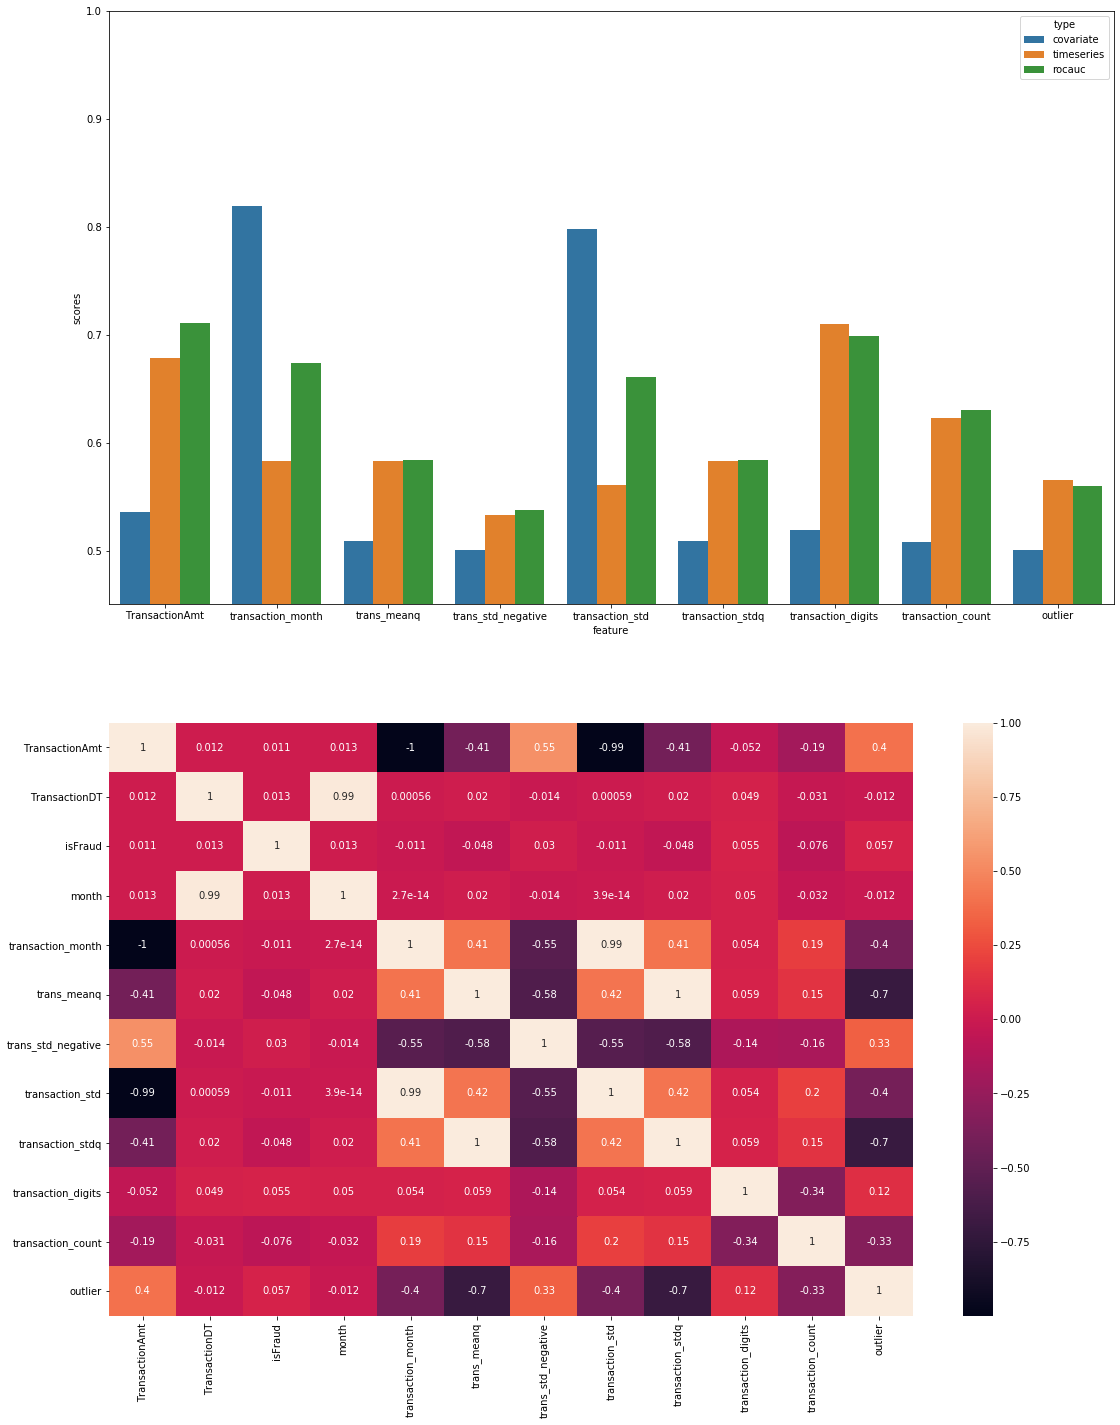

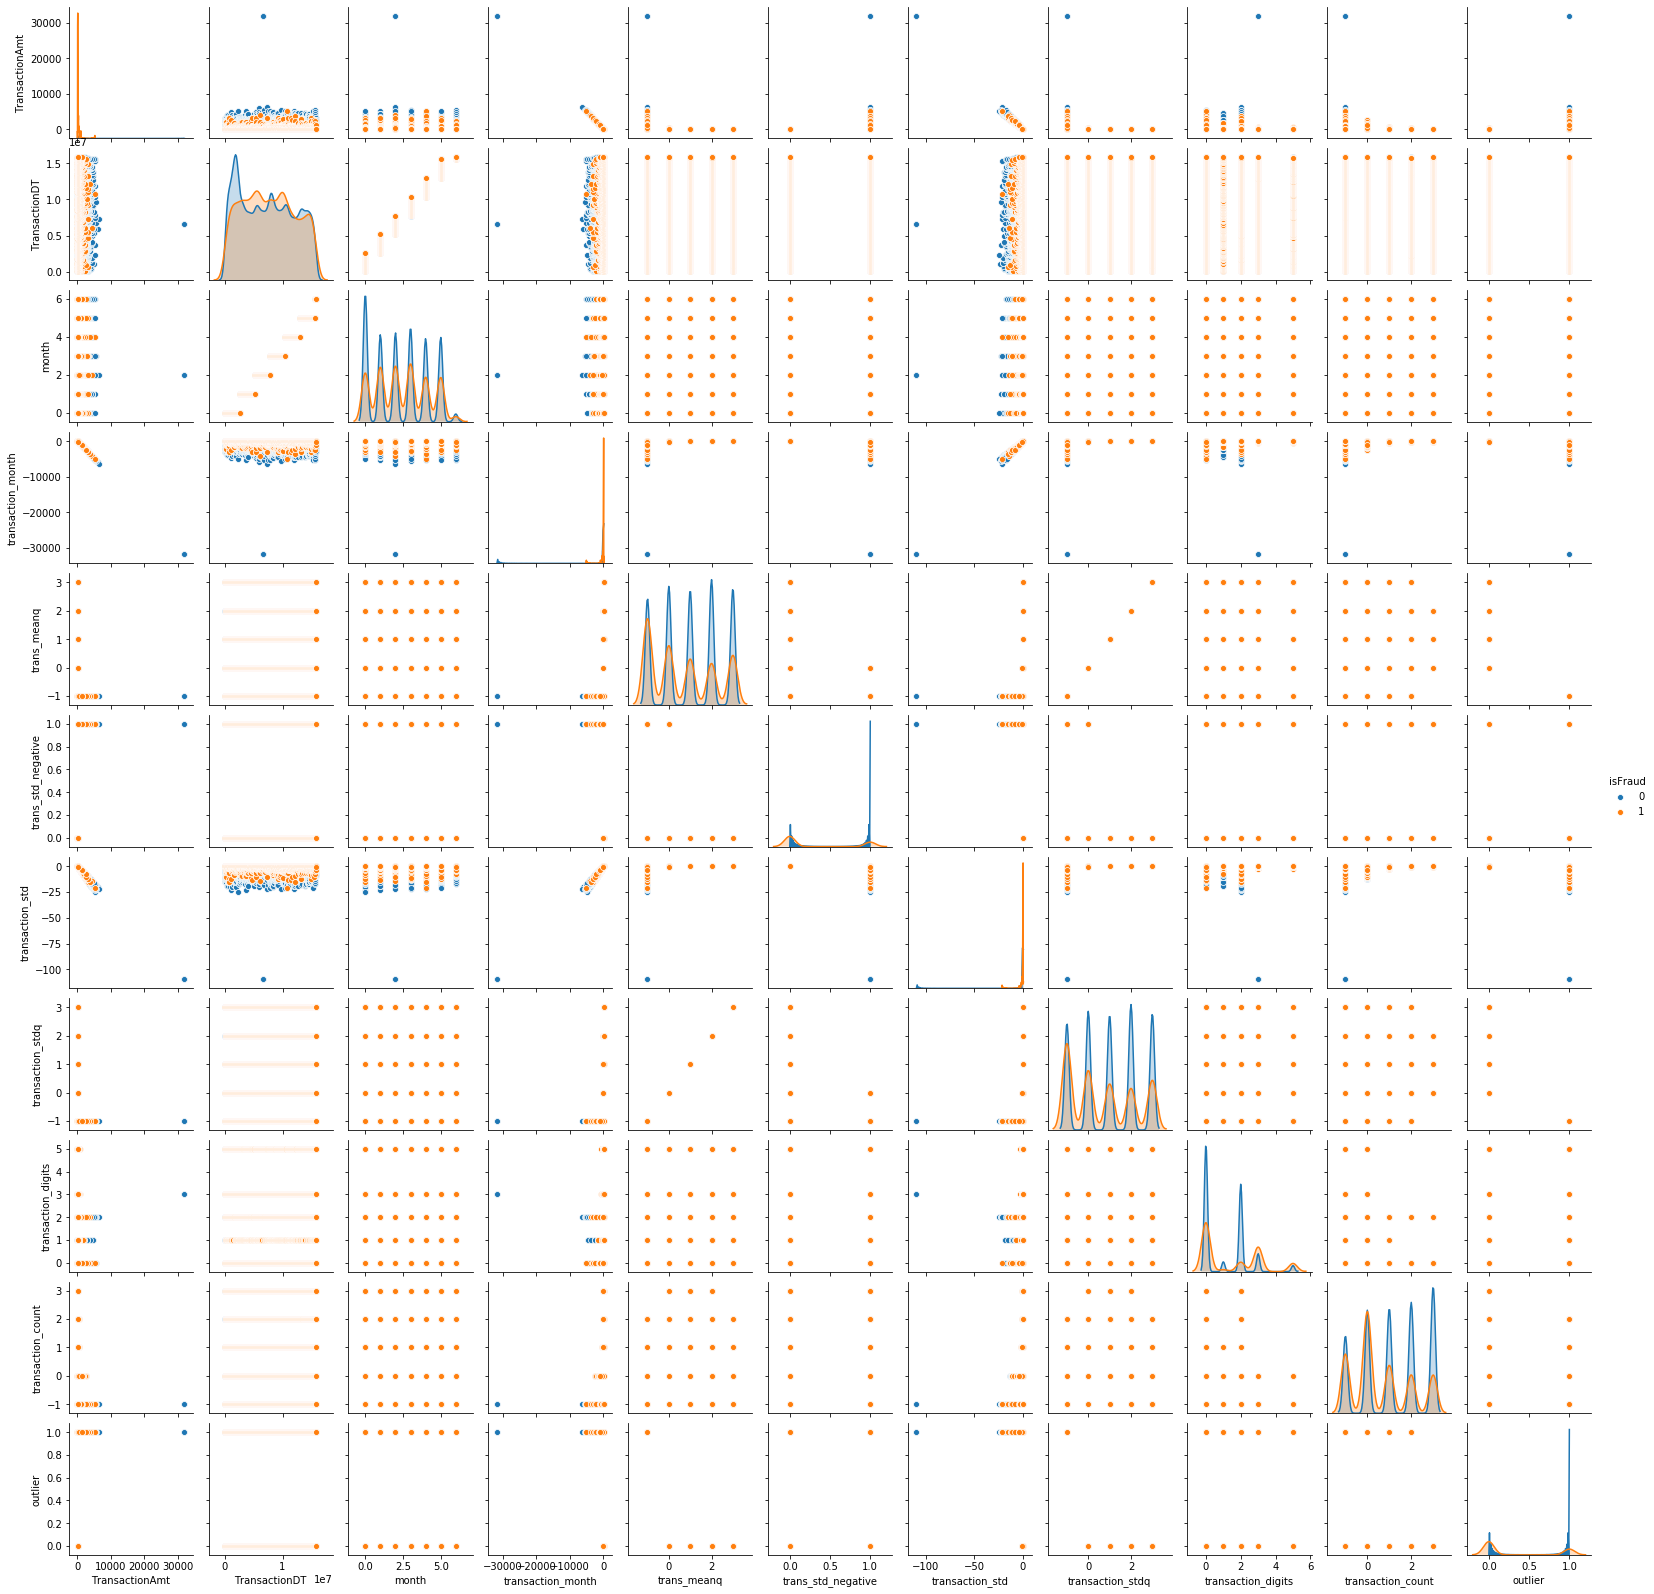

In [0]:
###TransactionAmt
df = pd.DataFrame(columns=["feature", "type", "scores"])

#transactionamt
df = get_info(data_trainTR['TransactionAmt'], data_testTR['TransactionAmt'], data_trainTR['isFraud'], df)

#transaction mean for each month
transaction_train = data_trainTR[['TransactionAmt', 'TransactionDT', 'isFraud']]
transaction_test = data_testTR[['TransactionAmt', 'TransactionDT']]
transaction_train['month'] = transaction_train['TransactionDT'] // (86400 * 30)
transaction_test['month'] = transaction_test['TransactionDT'] // (86400 * 30)
transaction_train['transaction_month'] = transaction_train.groupby(['month'])['TransactionAmt'].transform('mean') - transaction_train['TransactionAmt']
transaction_test['transaction_month'] = transaction_test.groupby(['month'])['TransactionAmt'].transform('mean') - transaction_test['TransactionAmt']
df = get_info(transaction_train['transaction_month'], transaction_test['transaction_month'], data_trainTR['isFraud'], df)

#transaction mean on quantiles
transaction_train['trans_meanq'] = pd.qcut(transaction_train['TransactionAmt'].median() - transaction_train['TransactionAmt'], [0.1, 0.3, 0.5, 0.7, 0.9], labels=False).fillna(-1)
transaction_test['trans_meanq'] = pd.qcut(transaction_test['TransactionAmt'].median() - transaction_test['TransactionAmt'], [0.1, 0.3, 0.5, 0.7, 0.9], labels=False).fillna(-1)
df = get_info(transaction_train['trans_meanq'], transaction_test['trans_meanq'], data_trainTR['isFraud'], df)

#transaction deviation is negative
transaction_train['trans_std_negative'] = np.where((transaction_train['transaction_month'] < 0), 1, 0)
transaction_test['trans_std_negative'] = np.where((transaction_test['transaction_month'] < 0), 1, 0)
df = get_info(transaction_train['trans_std_negative'], transaction_test['trans_std_negative'], data_trainTR['isFraud'], df)

#transaction std
transaction_train['transaction_std'] = transaction_train['transaction_month'] / transaction_train.groupby(['month'])['TransactionAmt'].transform('std')
transaction_test['transaction_std'] = transaction_test['transaction_month'] / transaction_test.groupby(['month'])['TransactionAmt'].transform('std')
df = get_info(transaction_train['transaction_std'], transaction_test['transaction_std'], data_trainTR['isFraud'], df)

#transaction std on quantiles
transaction_train['transaction_stdq'] = (transaction_train['TransactionAmt'].median() - transaction_train['TransactionAmt']) / transaction_train['TransactionAmt'].std()
transaction_train['transaction_stdq'] = pd.qcut(transaction_train['transaction_stdq'], [0.1, 0.3, 0.5, 0.7, 0.9], labels=False).fillna(-1)
transaction_test['transaction_stdq'] = (transaction_test['TransactionAmt'].median() - transaction_test['TransactionAmt']) / transaction_test['TransactionAmt'].std()
transaction_test['transaction_stdq'] = pd.qcut(transaction_test['transaction_stdq'], [0.1, 0.3, 0.5, 0.7, 0.9], labels=False).fillna(-1)
df = get_info(transaction_train['transaction_stdq'], transaction_test['transaction_stdq'], data_trainTR['isFraud'], df)

#transaction digits
def decimal_places(x):
        decimal_str = str(x)[str(x).find(".") +1:]
        if decimal_str == "0":
            return 0
        decimal_len = len(str(int(decimal_str[::-1])))
        return decimal_len if decimal_len < 5 else 5
transaction_train['transaction_digits'] = transaction_train['TransactionAmt'].map(decimal_places)
transaction_test['transaction_digits'] = transaction_test['TransactionAmt'].map(decimal_places)
df = get_info(transaction_train['transaction_digits'], transaction_test['transaction_digits'], data_trainTR['isFraud'], df)
      
#transaction count encoding
transaction_train['transaction_count'] = transaction_train['TransactionAmt'].map(transaction_train['TransactionAmt'].value_counts())
transaction_test['transaction_count'] = transaction_test['TransactionAmt'].map(transaction_test['TransactionAmt'].value_counts())
transaction_train['transaction_count'] = pd.qcut(transaction_train['transaction_count'], [0.1, 0.3, 0.5, 0.7, 0.9], labels=False).fillna(-1)
transaction_test['transaction_count'] = pd.qcut(transaction_test['transaction_count'], [0.1, 0.3, 0.5, 0.7, 0.9], labels=False).fillna(-1)
df = get_info(transaction_train['transaction_count'], transaction_test['transaction_count'], data_trainTR['isFraud'], df)

#transaction in outlier
high_tr = transaction_train['TransactionAmt'].quantile([0.9]).to_list()[0]
lower_tr = transaction_train['TransactionAmt'].quantile([0.1]).to_list()[0]
transaction_train['outlier'] = np.where((transaction_train['TransactionAmt'] > high_tr) | (transaction_train['TransactionAmt'] < lower_tr), 1, 0)
high_te = transaction_test['TransactionAmt'].quantile([0.9]).to_list()[0]
lower_te = transaction_test['TransactionAmt'].quantile([0.1]).to_list()[0]
transaction_test['outlier'] = np.where((transaction_test['TransactionAmt'] > high_te) | (transaction_test['TransactionAmt'] < lower_te), 1, 0)
df = get_info(transaction_train['outlier'], transaction_test['outlier'], data_trainTR['isFraud'], df)

#info
plot_info(transaction_train, df)

del transaction_train, transaction_test, df 
gc.collect()

225

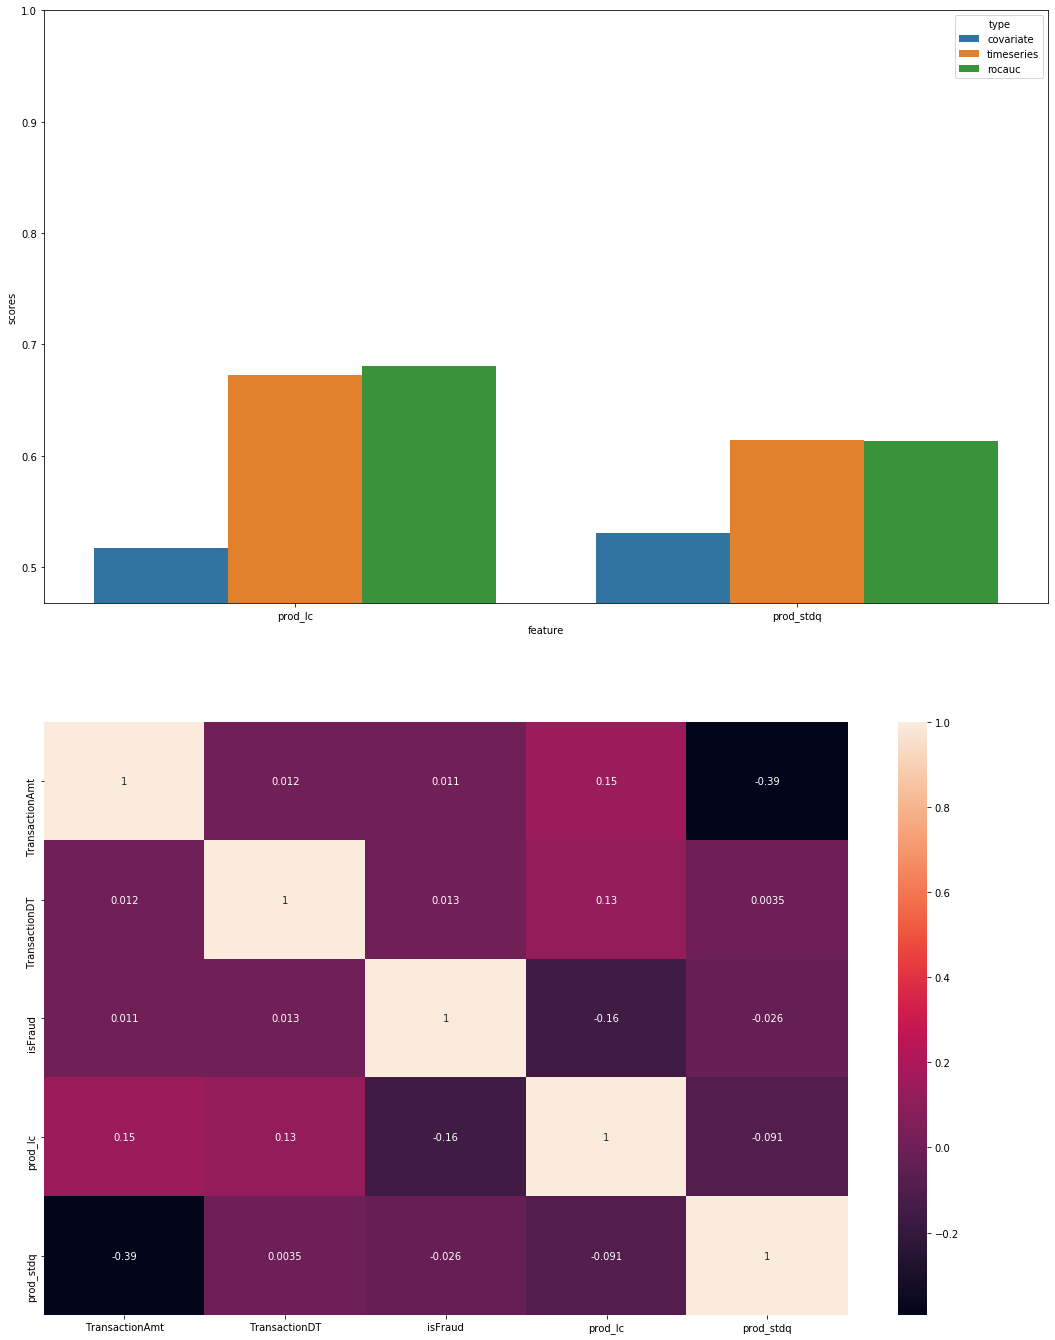

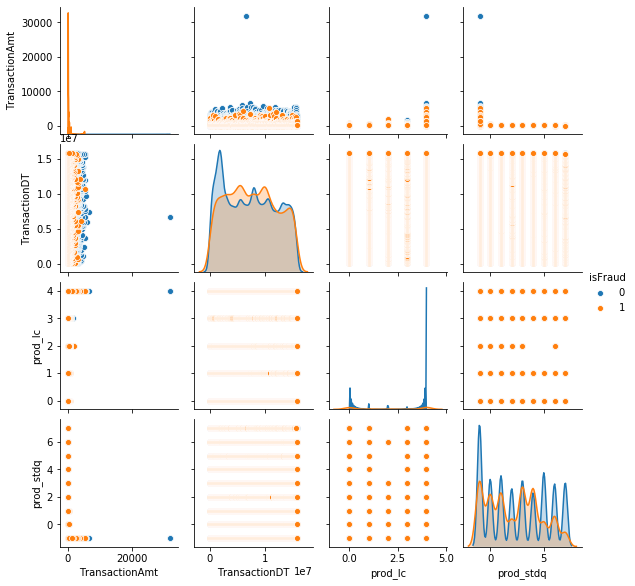

In [0]:
### productCD
df = pd.DataFrame(columns=["feature", "type", "scores"])

product_train = data_trainTR[['ProductCD', 'TransactionAmt', 'TransactionDT', 'isFraud']]
product_test = data_testTR[['ProductCD', 'TransactionAmt', 'TransactionDT']]
product_train['prod_lc'] = LabelEncoder().fit_transform(product_train['ProductCD'])
product_test['prod_lc'] = LabelEncoder().fit_transform(product_test['ProductCD'])

#productcd label encoded
df = get_info(product_train['prod_lc'], product_test['prod_lc'], data_trainTR['isFraud'], df)

#product std on quantiles
product_train['prod_stdq'] = pd.qcut(product_train.groupby(["ProductCD"])['TransactionAmt'].transform('median') - product_train['TransactionAmt'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
product_test['prod_stdq'] = pd.qcut(product_test.groupby(["ProductCD"])['TransactionAmt'].transform('median') - product_test['TransactionAmt'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
df = get_info(product_train['prod_stdq'], product_test['prod_stdq'], data_trainTR['isFraud'], df)

#plot info
plot_info(product_train, df)

del product_train, product_test, df
gc.collect()

540

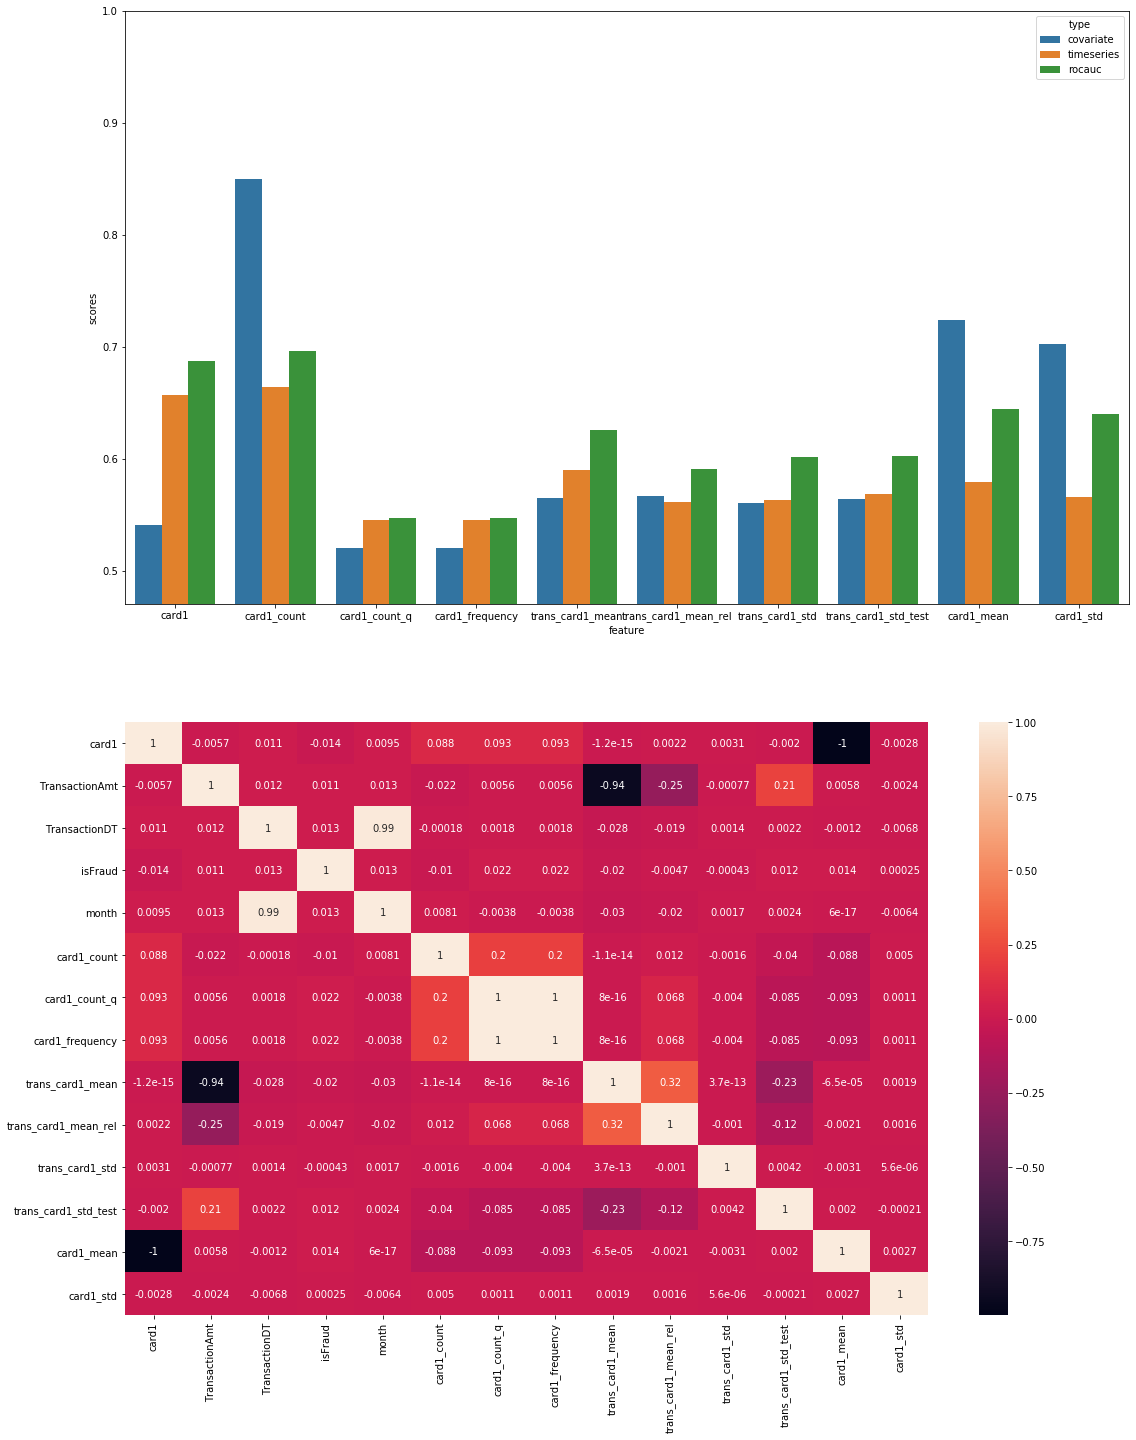

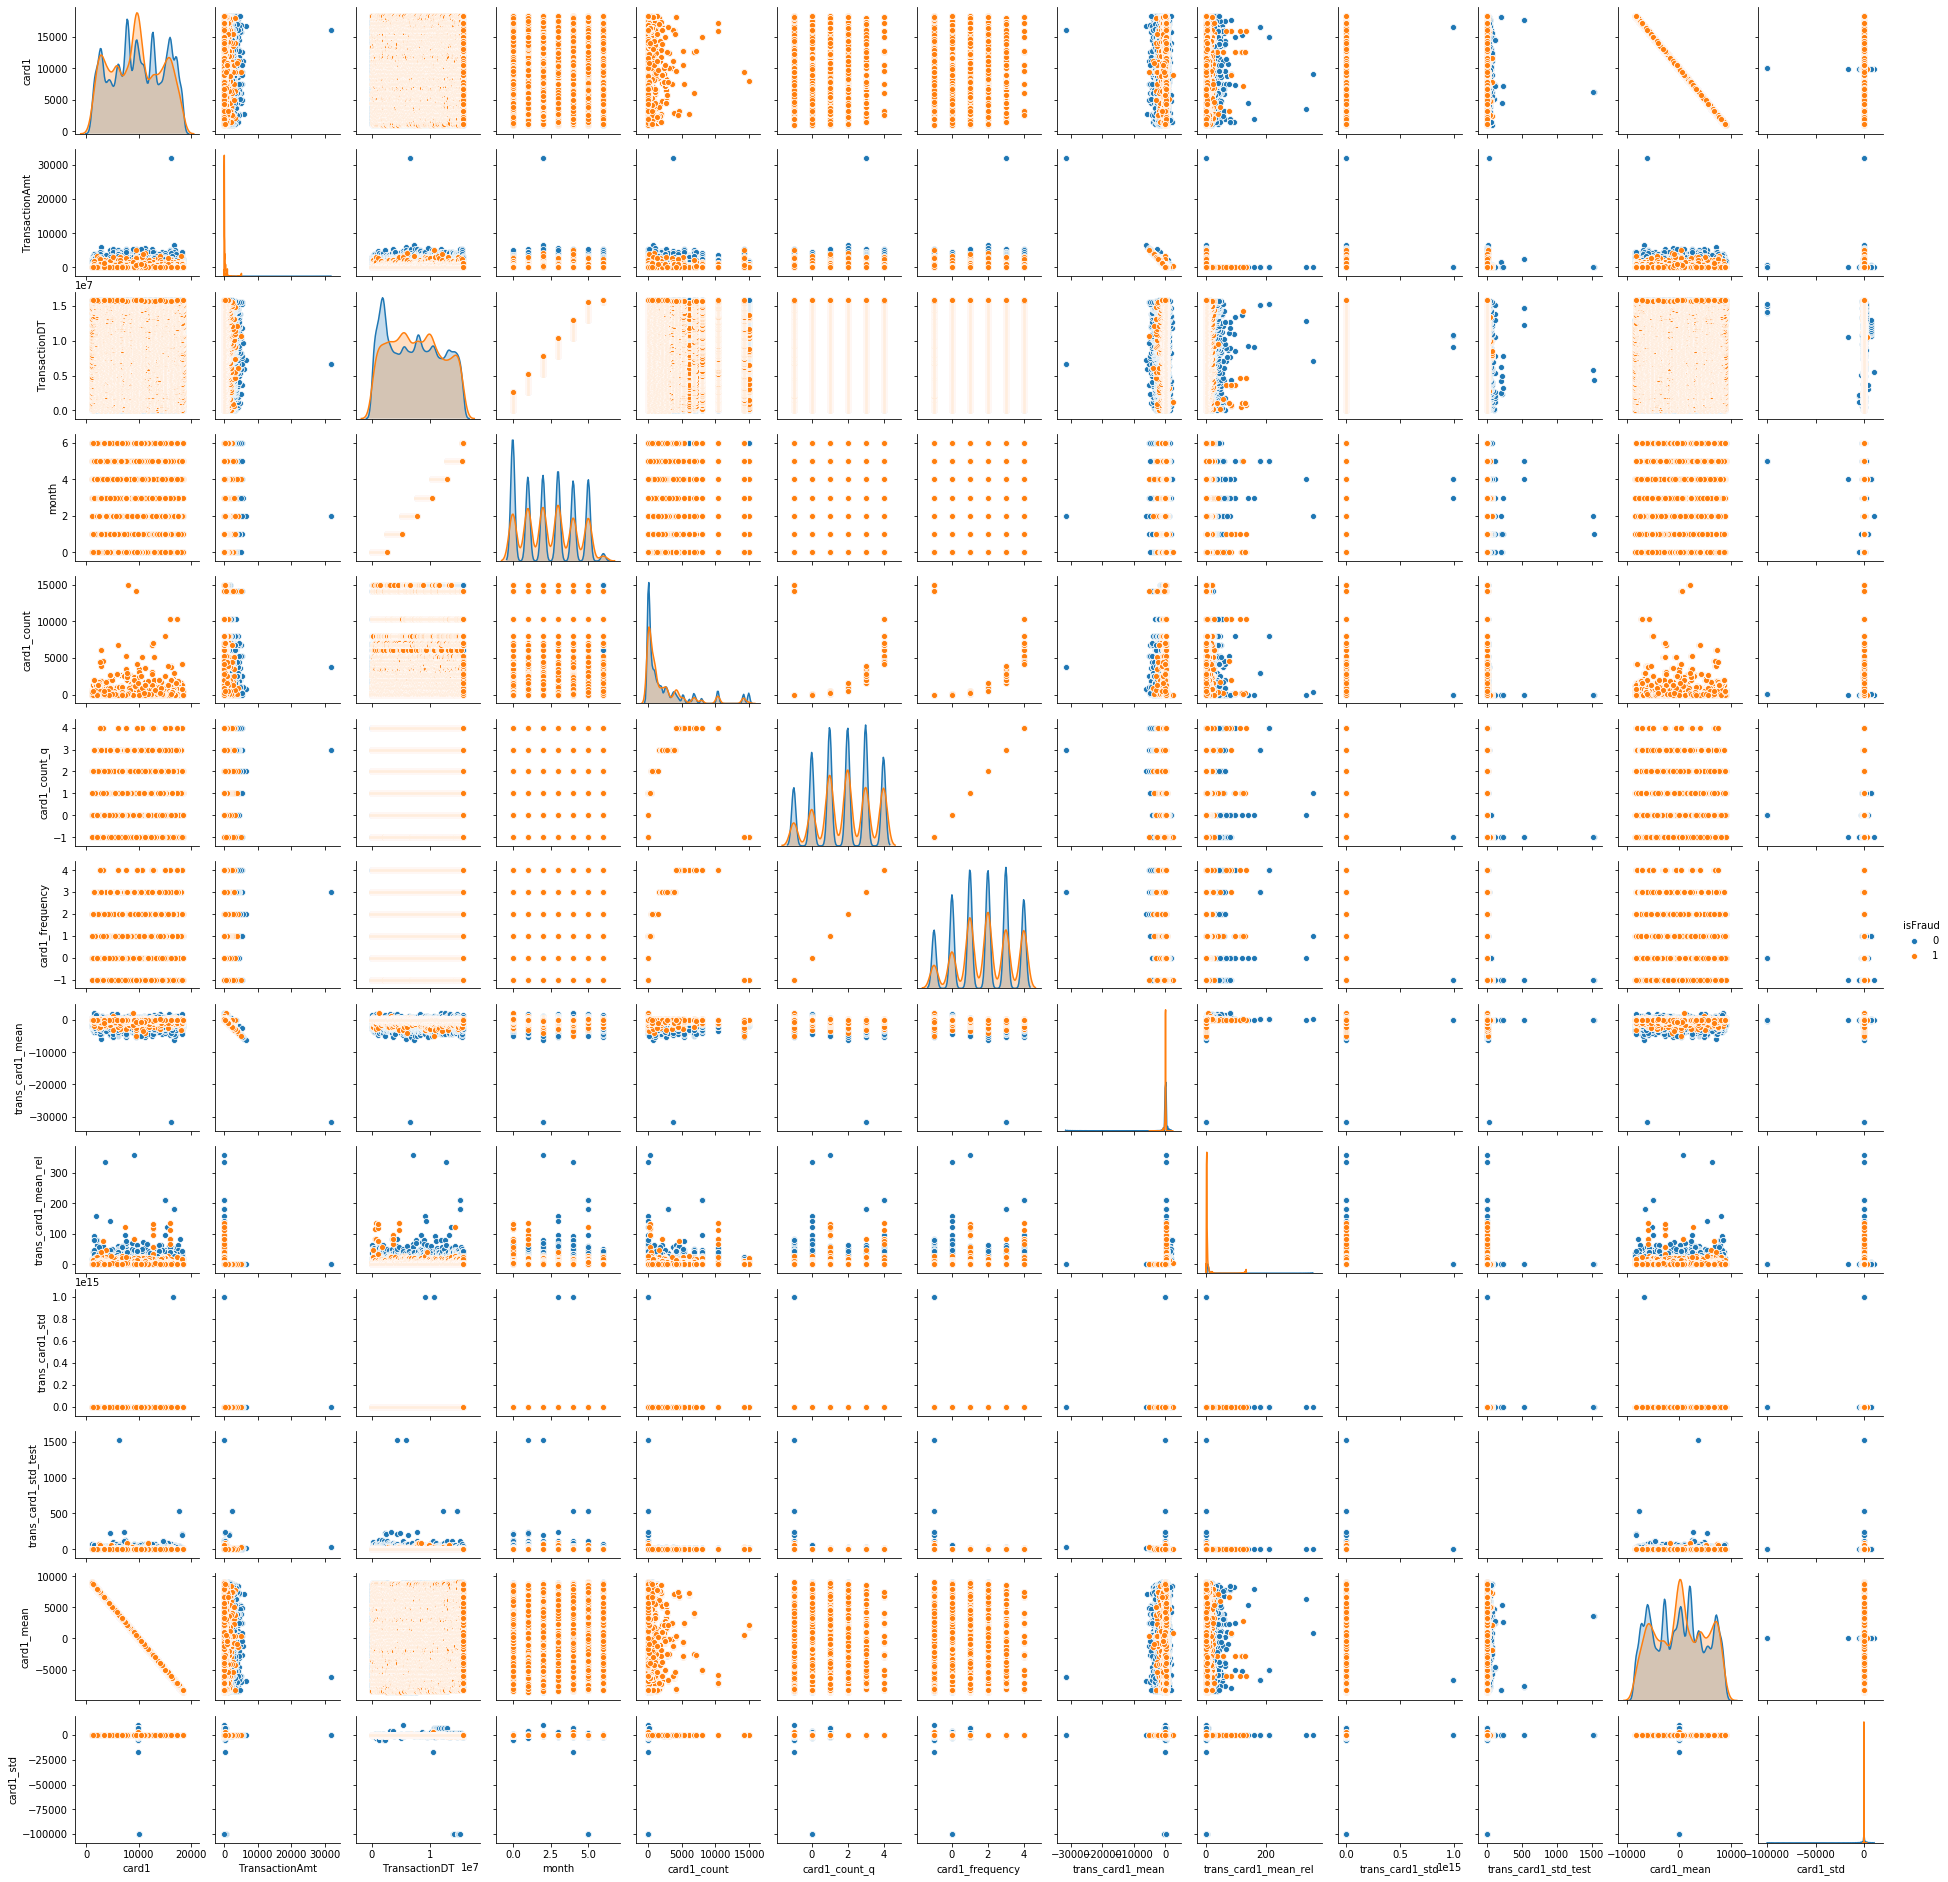

In [0]:
#card1
df = pd.DataFrame(columns=["feature", "type", "scores"])
card1_train = data_trainTR[['card1', 'TransactionAmt', 'TransactionDT', 'isFraud']]
card1_test = data_testTR[['card1', 'TransactionAmt', 'TransactionDT']]
card1_train['month'] = card1_train['TransactionDT'] // (86400 * 30)
card1_test['month'] = card1_test['TransactionDT'] // (86400 * 30)
df = get_info(card1_train['card1'], card1_test['card1'], data_trainTR['isFraud'], df)

#card1 counts
card1_train['card1_count'] = card1_train['card1'].map(card1_train['card1'].value_counts())
card1_test['card1_count'] = card1_test['card1'].map(card1_test['card1'].value_counts())
df = get_info(card1_train['card1_count'], card1_test['card1_count'], data_trainTR['isFraud'], df)

#card1 counts with quantiles
card1_train['card1_count_q'] = card1_train['card1'].map(card1_train['card1'].value_counts())
card1_test['card1_count_q'] = card1_test['card1'].map(card1_test['card1'].value_counts())
card1_train['card1_count_q'] = pd.qcut(card1_train['card1_count_q'], [0.05, 0.2, 0.4, 0.6, 0.8, 0.95], labels=False).fillna(-1)
card1_test['card1_count_q'] = pd.qcut(card1_test['card1_count_q'], [0.05, 0.2, 0.4, 0.6, 0.8, 0.95], labels=False).fillna(-1)
df = get_info(card1_train['card1_count_q'], card1_test['card1_count_q'], data_trainTR['isFraud'], df)

#card1 frequency encoding
card1_train['card1_frequency'] = card1_train['card1'].map(card1_train['card1'].value_counts() / card1_train['card1'].shape[0])
card1_test['card1_frequency'] = card1_test['card1'].map(card1_test['card1'].value_counts() / card1_test['card1'].shape[0])
card1_train['card1_frequency'] = pd.qcut(card1_train['card1_frequency'], [0.05, 0.2, 0.4, 0.6, 0.8, 0.95], labels=False).fillna(-1)
card1_test['card1_frequency'] = pd.qcut(card1_test['card1_frequency'], [0.05, 0.2, 0.4, 0.6, 0.8, 0.95], labels=False).fillna(-1)
df = get_info(card1_train['card1_frequency'], card1_test['card1_frequency'], data_trainTR['isFraud'], df)

#transaction card1 mean
card1_train['trans_card1_mean'] = card1_train.groupby(['card1'])['TransactionAmt'].transform('mean') - card1_train['TransactionAmt']
card1_test['trans_card1_mean'] = card1_test.groupby(['card1'])['TransactionAmt'].transform('mean') - card1_test['TransactionAmt']
df = get_info(card1_train['trans_card1_mean'], card1_test['trans_card1_mean'], data_trainTR['isFraud'], df)

#transaction card1 mean relatively
card1_train['trans_card1_mean_rel'] = card1_train.groupby(['card1'])['TransactionAmt'].transform('mean') / card1_train['TransactionAmt']
card1_test['trans_card1_mean_rel'] = card1_test.groupby(['card1'])['TransactionAmt'].transform('mean') / card1_test['TransactionAmt']
df = get_info(card1_train['trans_card1_mean_rel'], card1_test['trans_card1_mean_rel'], data_trainTR['isFraud'], df)

#transaction card1 std
card1_train['trans_card1_std'] = card1_train.groupby(['card1'])['TransactionAmt'].transform('std') / card1_train['trans_card1_mean']
card1_test['trans_card1_std'] = card1_test.groupby(['card1'])['TransactionAmt'].transform('std') / card1_test['trans_card1_mean']
df = get_info(card1_train['trans_card1_std'], card1_test['trans_card1_std'], data_trainTR['isFraud'], df)

#transaction card1 std in kaggle(test)
card1_train['trans_card1_std_test'] = card1_train['TransactionAmt'] / card1_train.groupby(['card1'])['TransactionAmt'].transform('std')
card1_test['trans_card1_std_test'] = card1_test['TransactionAmt'] / card1_test.groupby(['card1'])['TransactionAmt'].transform('std')
df = get_info(card1_train['trans_card1_std_test'], card1_test['trans_card1_std_test'], data_trainTR['isFraud'], df)

#card1 mean on month
card1_train['card1_mean'] = card1_train.groupby(['month'])['card1'].transform('mean') - card1_train['card1']
card1_test['card1_mean'] = card1_test.groupby(['month'])['card1'].transform('mean') - card1_test['card1']
df = get_info(card1_train['card1_mean'], card1_test['card1_mean'], data_trainTR['isFraud'], df)

#card1 std on month
card1_train['card1_std'] = card1_train.groupby(['month'])['card1'].transform('std') / card1_train['card1_mean']
card1_test['card1_std'] = card1_test.groupby(['month'])['card1'].transform('std') / card1_test['card1_mean']
df = get_info(card1_train['card1_std'], card1_test['card1_std'], data_trainTR['isFraud'], df)

#plot info
plot_info(card1_train, df)

del card1_train, card1_test, df
gc.collect()

473

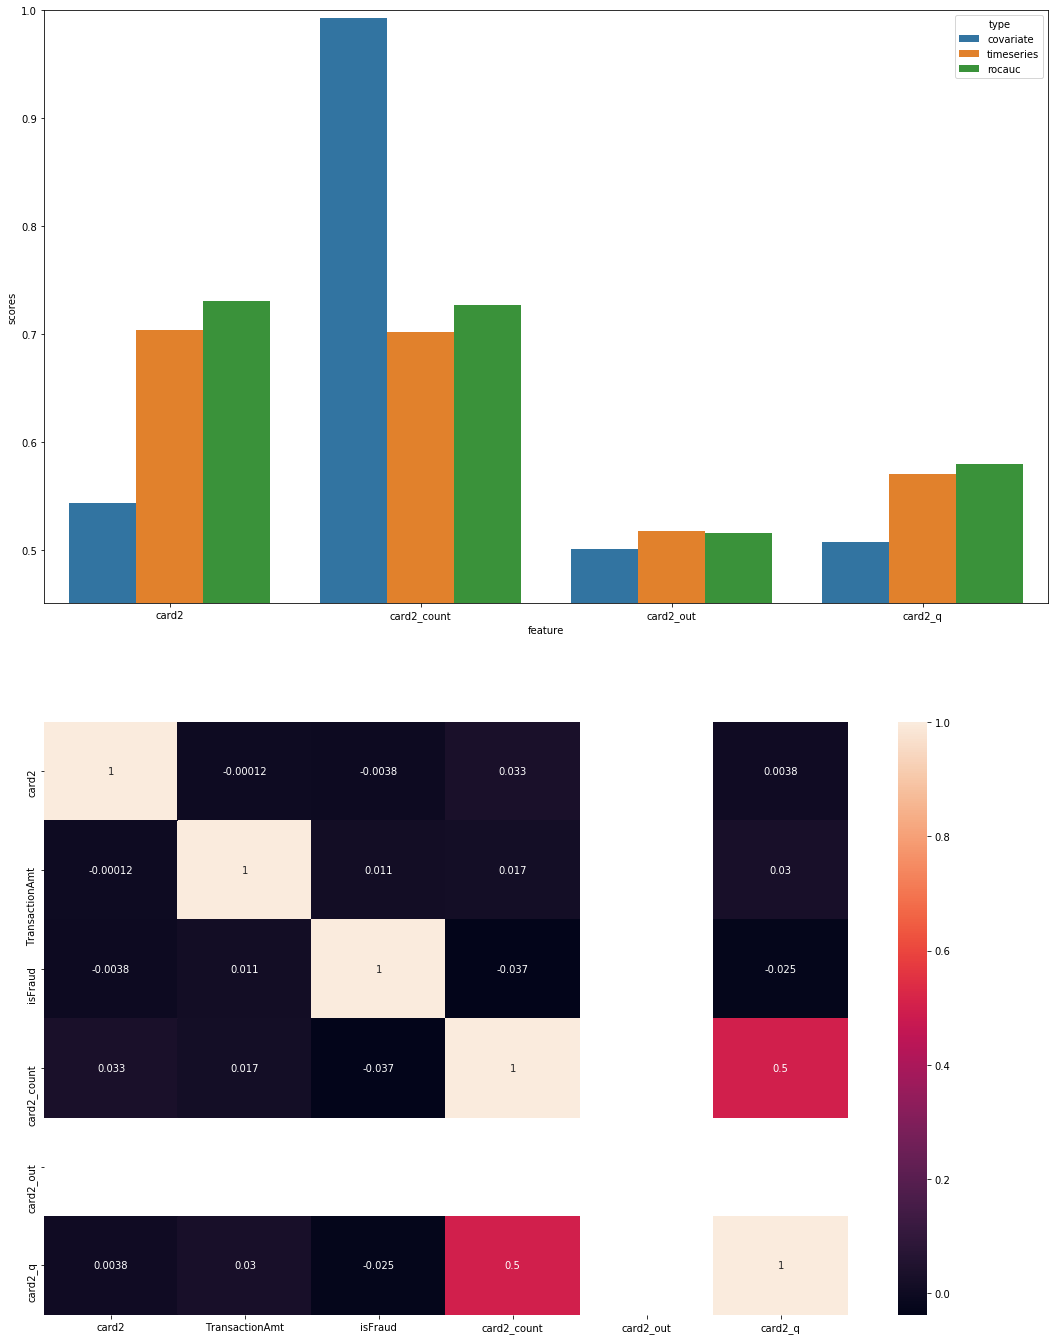

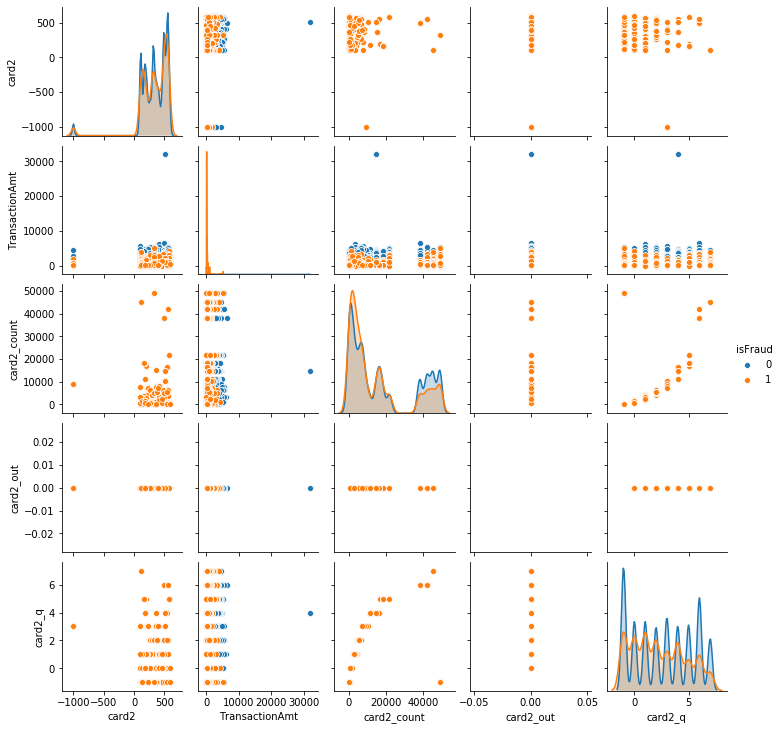

In [0]:
#card2
df = pd.DataFrame(columns=["feature", "type", "scores"])
card2_train = data_trainTR[['card2', 'TransactionAmt', 'isFraud']]
card2_test = data_testTR[['card2', 'TransactionAmt']]
card2_train['card2'] = card2_train['card2'].fillna(-999)
card2_test['card2'] = card2_test['card2'].fillna(-999)

#card2
df = get_info(card2_train['card2'], card2_test['card2'], data_trainTR['isFraud'], df)

#card2 count
card2_train['card2_count'] = card2_train['card2'].map(card2_train['card2'].value_counts())
card2_test['card2_count'] = card2_test['card2'].map(card2_test['card2'].value_counts())
df = get_info(card2_train['card2_count'], card2_test['card2_count'], data_trainTR['isFraud'], df)

#card2 count outliers
card2_train['card2_out'] = pd.qcut(card2_train['card2_count'], [0.1, 0.9], labels=False)
card2_test['card2_out'] = pd.qcut(card2_test['card2_count'], [0.1, 0.9], labels=False)
df = get_info(card2_train['card2_out'], card2_test['card2_out'], data_trainTR['isFraud'], df)

#card2 count with quantiles
card2_train['card2_q'] = pd.qcut(card2_train['card2_count'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
card2_test['card2_q'] = pd.qcut(card2_test['card2_count'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
df = get_info(card2_train['card2_q'], card2_test['card2_q'], data_trainTR['isFraud'], df)

#plot info
plot_info(card2_train, df)

del card2_train, card2_test, df
gc.collect()

In [4]:
#card3
card3_train = data_trainTR[['card3']]
card3_test = data_testTR[['card3']]
card3_train['card3'] = card3_train['card3'].fillna(-999)
card3_test['card3'] = card3_test['card3'].fillna(-999)

print('card3')
str_info(card3_train['card3'], card3_test['card3'], data_trainTR['isFraud'])

print('card3 outliers')
card3_train['card3_o'] = np.where((card3_train['card3'] < card3_train['card3'].quantile(0.1)) | (card3_train['card3'] > card3_train['card3'].quantile(0.9)), 1, 0)
card3_test['card3_o'] = np.where((card3_test['card3'] < card3_test['card3'].quantile(0.1)) | (card3_test['card3'] > card3_test['card3'].quantile(0.9)), 1, 0)
str_info(card3_train['card3_o'], card3_test['card3_o'], data_trainTR['isFraud'])

del card3_train, card3_test
gc.collect()

card3
//////////////////////////////
covariate:  0.5124483804978527
timeseries score:  0.6378103653626394
rocauc score:  0.6385178072751989
//////////////////////////////
card3 outliers
//////////////////////////////
covariate:  0.5419069888920675
timeseries score:  0.6365410227805929
rocauc score:  0.6358908854057989
//////////////////////////////


0

In [5]:
#card4
card4_train = data_trainTR[['card4', 'TransactionAmt']]
card4_test = data_testTR[['card4', 'TransactionAmt']]
card4_train['card4'] = card4_train.fillna("NAN")
card4_test['card4'] = card4_test.fillna("NAN")
card4_train['card4_lc'] = LabelEncoder().fit_transform(card4_train['card4'])
card4_test['card4_lc'] = LabelEncoder().fit_transform(card4_test['card4'])

print('card4')
str_info(card4_train['card4_lc'], card4_test['card4_lc'], data_trainTR['isFraud'])

print('\ncard4 count')
card4_train['card4_count'] = card4_train['card4'].map(card4_train['card4'].value_counts())
card4_test['card4_count'] = card4_test['card4'].map(card4_test['card4'].value_counts())
str_info(card4_train['card4_count'], card4_test['card4_count'], data_trainTR['isFraud'])

print('\ntransactionamt to card4 mean')
card4_train['trans_card_mean'] = card4_train.groupby(['card4'])['TransactionAmt'].transform('mean') - card4_train['TransactionAmt']
card4_test['trans_card_mean'] = card4_test.groupby(['card4'])['TransactionAmt'].transform('mean') - card4_test['TransactionAmt']
str_info(card4_train['trans_card_mean'], card4_test['trans_card_mean'], data_trainTR['isFraud'])

print('\ntransactionamt to card4 mean with quantiles')
card4_train['trans_card_mean_q'] = pd.qcut(card4_train['trans_card_mean'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
card4_test['trans_card_mean_q'] = pd.qcut(card4_test['trans_card_mean'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
str_info(card4_train['trans_card_mean_q'], card4_test['trans_card_mean_q'], data_trainTR['isFraud'])

print('\ntransactionamt to card4 std')
card4_train['trans_card_std'] = card4_train.groupby(['card4'])['TransactionAmt'].transform('std') / card4_train['trans_card_mean']
card4_test['trans_card_std'] = card4_test.groupby(['card4'])['TransactionAmt'].transform('std') / card4_test['trans_card_mean']
str_info(card4_train['trans_card_std'], card4_test['trans_card_std'], data_trainTR['isFraud'])

print('\ntransactionamt to card4 std quantiles')
card4_train['trans_card_std_q'] = pd.qcut(card4_train['trans_card_std'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
card4_test['trans_card_std_q'] = pd.qcut(card4_test['trans_card_std'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
str_info(card4_train['trans_card_std_q'], card4_test['trans_card_std_q'], data_trainTR['isFraud'])

del card4_train, card4_test
gc.collect()

card4
//////////////////////////////
covariate:  0.5091414160089398
timeseries score:  0.5016399533135387
rocauc score:  0.5099398899465384
//////////////////////////////

card4 count
//////////////////////////////
covariate:  1.0
timeseries score:  0.501189863186405
rocauc score:  0.5099398899465384
//////////////////////////////

transactionamt to card4 mean
//////////////////////////////
covariate:  0.9146761922778743
timeseries score:  0.6600926300494298
rocauc score:  0.6857589402852698
//////////////////////////////

transactionamt to card4 mean with quantiles
//////////////////////////////
covariate:  0.5051892432039289
timeseries score:  0.5927887572642306
rocauc score:  0.591600100144462
//////////////////////////////

transactionamt to card4 std
//////////////////////////////
covariate:  0.9039817425458763
timeseries score:  0.6479308435182648
rocauc score:  0.6841224559947032
//////////////////////////////

transactionamt to card4 std quantiles
//////////////////////////////

0

In [6]:
#card5
card5_train = data_trainTR[['card5']]
card5_test = data_testTR[['card5']]
card5_train['card5'] = card5_train['card5'].fillna(-999)
card5_test['card5'] = card5_test['card5'].fillna(-999)

print('card5')
str_info(card5_train['card5'], card5_test['card5'], data_trainTR['isFraud'])

print('\ncard5 is outlier')
card5_train['card5_o'] = np.where(((card5_train['card5'] < card5_train['card5'].quantile(0.05)) | (card5_train['card5'] > card5_train['card5'].quantile(0.95))), 1, 0)
card5_test['card5_o'] = np.where(((card5_test['card5'] < card5_test['card5'].quantile(0.05)) | (card5_test['card5'] > card5_test['card5'].quantile(0.95))), 1, 0)
str_info(card5_train['card5_o'], card5_test['card5_o'], data_trainTR['isFraud'])

del card5_train, card5_test
gc.collect()

card5
//////////////////////////////
covariate:  0.5304760115233447
timeseries score:  0.6417827801200876
rocauc score:  0.6454330936781515
//////////////////////////////

card5 is outlier
//////////////////////////////
covariate:  0.5212659047216794
timeseries score:  0.4998489867665939
rocauc score:  0.4997035405069358
//////////////////////////////


0

In [7]:
#card6
card6_train = data_trainTR[['card6', 'TransactionAmt']]
card6_test = data_testTR[['card6', 'TransactionAmt']]
card6_train['card6'] = card6_train['card6'].fillna("NAN")
card6_test['card6'] = card6_test['card6'].fillna("NAN")

print('card6')
card6_train['card6_lc'] = LabelEncoder().fit_transform(card6_train['card6'])
card6_test['card6_lc'] = LabelEncoder().fit_transform(card6_test['card6'])
str_info(card6_train['card6_lc'], card6_test['card6_lc'], data_trainTR['isFraud'])

print('\ntransactionamt to card6 median diviation')
card6_train['trans_card_med'] = card6_train.groupby(['card6'])['TransactionAmt'].transform('median') - card6_train['TransactionAmt']
card6_test['trans_card_med'] = card6_test.groupby(['card6'])['TransactionAmt'].transform('median') - card6_test['TransactionAmt']
str_info(card6_train['trans_card_med'], card6_test['trans_card_med'], data_trainTR['isFraud'])

del card6_train, card6_test
gc.collect()

card6
//////////////////////////////
covariate:  0.5108086485216861
timeseries score:  0.6313490172830986
rocauc score:  0.6200824799670823
//////////////////////////////

transactionamt to card6 median diviation
//////////////////////////////
covariate:  0.5359054981595437
timeseries score:  0.6842701267737713
rocauc score:  0.7123463370884022
//////////////////////////////


0

In [8]:
#addr1

addr1_train = data_trainTR[['addr1', 'TransactionAmt', 'card1']]
addr1_test = data_testTR[['addr1', 'TransactionAmt', 'card1']]
addr1_train['isnull'] = addr1_train['addr1'].isnull().astype(int)
addr1_test['isnull'] = addr1_test['addr1'].isnull().astype(int)
addr1_train['addr1'] = addr1_train['addr1'].fillna(-999)
addr1_test['addr1'] = addr1_test['addr1'].fillna(-999)

print('addr1')
str_info(addr1_train['addr1'], addr1_test['addr1'], data_trainTR['isFraud'])

print('\naddr1 is null feature')
str_info(addr1_train['isnull'], addr1_test['isnull'], data_trainTR['isFraud'])

print('\naddr1 to transactionamt')
addr1_train['addr_trans'] = addr1_train.groupby(['addr1'])['TransactionAmt'].transform('median') - addr1_train['TransactionAmt']
addr1_test['addr_trans'] = addr1_test.groupby(['addr1'])['TransactionAmt'].transform('median') - addr1_test['TransactionAmt']
str_info(addr1_train['addr_trans'], addr1_test['addr_trans'], data_trainTR['isFraud'])

print('\naddr1, transactionamt mean agg')
addr1_train['addr_trans_mean'] = addr1_train.groupby('addr1').TransactionAmt.agg(['mean'])
addr1_test['addr_trans_mean'] = addr1_test.groupby('addr1').TransactionAmt.agg(['mean'])
str_info(addr1_train['addr_trans_mean'], addr1_test['addr_trans_mean'], data_trainTR['isFraud'])

print('\naddr1 to transactionamt with quantiles')
addr1_train['addr_trans_q'] = pd.qcut(addr1_train['addr_trans'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
addr1_test['addr_trans_q'] = pd.qcut(addr1_test['addr_trans'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
str_info(addr1_train['addr_trans_q'], addr1_test['addr_trans_q'], data_trainTR['isFraud'])

print('\naddr1 to card1')
addr1_train['addr_card'] = addr1_train.groupby(['addr1'])['card1'].transform('median') - addr1_train['card1']
addr1_test['addr_card'] = addr1_test.groupby(['addr1'])['card1'].transform('median') - addr1_test['card1']
str_info(addr1_train['addr_card'], addr1_test['addr_card'], data_trainTR['isFraud'])

print('\naddr1 to card1 with quantiles')
addr1_train['addr_card_q'] = pd.qcut(addr1_train['addr_card'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
addr1_test['addr_card_q'] = pd.qcut(addr1_test['addr_card'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
str_info(addr1_train['addr_card_q'], addr1_test['addr_card_q'], data_trainTR['isFraud'])

print('\naddr1 - card1 iteraction')
addr1_train['addrcard'] = addr1_train['addr1'].astype(str) + "_" + addr1_train['card1'].astype(str)
addr1_test['addrcard'] = addr1_test['addr1'].astype(str) + "_" + addr1_test['card1'].astype(str)
addr1_train['addrcard'] = LabelEncoder().fit_transform(addr1_train['addrcard'])
addr1_test['addrcard'] = LabelEncoder().fit_transform(addr1_test['addrcard'])
str_info(addr1_train['addrcard'], addr1_test['addrcard'], data_trainTR['isFraud'])

del addr1_train, addr1_test
gc.collect()

addr1
//////////////////////////////
covariate:  0.5214947092173235
timeseries score:  0.6625887844884208
rocauc score:  0.6883487720537754
//////////////////////////////

addr1 is null feature
//////////////////////////////
covariate:  0.5090837124311305
timeseries score:  0.640670775049625
rocauc score:  0.6361961670314081
//////////////////////////////

addr1 to transactionamt
//////////////////////////////
covariate:  0.6013684628563476
timeseries score:  0.632770657481054
rocauc score:  0.6654004797917034
//////////////////////////////

addr1, transactionamt mean agg
//////////////////////////////
covariate:  0.5000080999185081
timeseries score:  0.5
rocauc score:  0.500201879908458
//////////////////////////////

addr1 to transactionamt with quantiles
//////////////////////////////
covariate:  0.5130709897164738
timeseries score:  0.5728652358307045
rocauc score:  0.5707475342283431
//////////////////////////////

addr1 to card1
//////////////////////////////
covariate:  0.674963

0

In [9]:
#addr2 & dist1 & dist2
addrdist_train = data_trainTR[['addr2', 'dist1', 'dist2']]
addrdist_test = data_testTR[['addr2', 'dist1', 'dist2']]
addrdist_train = addrdist_train.fillna(-999)
addrdist_test = addrdist_test.fillna(-999)

print('addr2')
str_info(addrdist_train['addr2'], addrdist_test['addr2'], data_trainTR['isFraud'])

print('\ndist1')
str_info(addrdist_train['dist1'], addrdist_test['dist1'], data_trainTR['isFraud'])

print('\ndist2')
str_info(addrdist_train['dist2'], addrdist_test['dist2'], data_trainTR['isFraud'])

del addrdist_train, addrdist_test
gc.collect()

addr2
//////////////////////////////
covariate:  0.5110623023146634
timeseries score:  0.6436921809640732
rocauc score:  0.6448788591542207
//////////////////////////////

dist1
//////////////////////////////
covariate:  0.5222645355523333
timeseries score:  0.6073251042049601
rocauc score:  0.6108023628208887
//////////////////////////////

dist2
//////////////////////////////
covariate:  0.5143900855445597
timeseries score:  0.5497938160764083
rocauc score:  0.5630437055038606
//////////////////////////////


0

In [10]:
#p_emaildomain
pemail_train = data_trainTR[['P_emaildomain']]
pemail_test = data_testTR[['P_emaildomain']]

def pemail_map(email):
  mapping= {'frontier.com':'frontier','frontiernet.net':'frontier','gmail':'gmail','gmail.com':'gmail','hotmail.co.uk':'hotmail','hotmail.com':'Microsoft','hotmail.de':'Microsoft',
            'hotmail.es':'Microsoft','hotmail.fr':'Microsoft','icloud.com':'Apple','live.com':'Microsoft','live.com.mx':'Microsoft','live.fr':'Microsoft','mac.com':'Apple',
            'netzero.com':'Netzero','netzero.net':'Netzero','outlook.com':'Microsoft','outlook.es':'Microsoft', 'yahoo.co.jp':'Yahoo','yahoo.co.uk':'Yahoo','yahoo.com':'Yahoo',
            'yahoo.com.mx':'Yahoo','yahoo.de':'Yahoo','yahoo.es':'Yahoo','yahoo.fr':'Yahoo','ymail.com':'Yahoo', 'scranton.edu':'Scranton'}
  if email in mapping.keys():
    return mapping[email]
  elif pd.isnull(email):
    return 'NAN'
  else:
    return 'other'

pemail_train = pd.get_dummies(pemail_train['P_emaildomain'].map(pemail_map))
pemail_test = pd.get_dummies(pemail_test['P_emaildomain'].map(pemail_map))

for email in pemail_train.columns.to_list():
  print(f'\nP_emaildomain(OHE): {email}')
  str_info(pemail_train[email], pemail_test[email], data_trainTR['isFraud'])

del pemail_train, pemail_test
gc.collect()


P_emaildomain(OHE): Apple
//////////////////////////////
covariate:  0.5006361862494335
timeseries score:  0.500660464850678
rocauc score:  0.5004234174667854
//////////////////////////////

P_emaildomain(OHE): Microsoft
//////////////////////////////
covariate:  0.5029688427103992
timeseries score:  0.5265039741512813
rocauc score:  0.5294532882981636
//////////////////////////////

P_emaildomain(OHE): NAN
//////////////////////////////
covariate:  0.5115905259093052
timeseries score:  0.513959700336131
rocauc score:  0.5147244224037277
//////////////////////////////

P_emaildomain(OHE): Netzero
//////////////////////////////
covariate:  0.5000926189239391
timeseries score:  0.5003686024525181
rocauc score:  0.50036712672789
//////////////////////////////

P_emaildomain(OHE): Yahoo
//////////////////////////////
covariate:  0.5051555791571635
timeseries score:  0.5325891677832711
rocauc score:  0.5314961160000279
//////////////////////////////

P_emaildomain(OHE): frontier
//////////

0

In [11]:
#r_emaildomain
remail_train = data_trainTR[['R_emaildomain']]
remail_test = data_testTR[['R_emaildomain']]

def pemail_map(email):
  mapping= {'frontier.com':'frontier','frontiernet.net':'frontier','gmail':'gmail','gmail.com':'gmail','hotmail.co.uk':'hotmail','hotmail.com':'Microsoft','hotmail.de':'Microsoft',
            'hotmail.es':'Microsoft','hotmail.fr':'Microsoft','icloud.com':'Apple','live.com':'Microsoft','live.com.mx':'Microsoft','live.fr':'Microsoft','mac.com':'Apple',
            'netzero.com':'Netzero','netzero.net':'Netzero','outlook.com':'Microsoft','outlook.es':'Microsoft', 'yahoo.co.jp':'Yahoo','yahoo.co.uk':'Yahoo','yahoo.com':'Yahoo',
            'yahoo.com.mx':'Yahoo','yahoo.de':'Yahoo','yahoo.es':'Yahoo','yahoo.fr':'Yahoo','ymail.com':'Yahoo', 'scranton.edu':'Scranton'}
  if email in mapping.keys():
    return mapping[email]
  elif pd.isnull(email):
    return 'NAN'
  else:
    return 'other'

remail_train = pd.get_dummies(remail_train['R_emaildomain'].map(pemail_map))
remail_test = pd.get_dummies(remail_test['R_emaildomain'].map(pemail_map))

for email in remail_train.columns.to_list():
  print(f'\nR_emaildomain(OHE): {email}')
  str_info(remail_train[email], remail_test[email], data_trainTR['isFraud'])

del remail_train, remail_test
gc.collect()


R_emaildomain(OHE): Apple
//////////////////////////////
covariate:  0.5002353151712798
timeseries score:  0.5038736215564384
rocauc score:  0.5026283865329606
//////////////////////////////

R_emaildomain(OHE): Microsoft
//////////////////////////////
covariate:  0.5027854506012018
timeseries score:  0.5389009239526689
rocauc score:  0.5397250175935755
//////////////////////////////

R_emaildomain(OHE): NAN
//////////////////////////////
covariate:  0.5184254192591056
timeseries score:  0.6815296248149769
rocauc score:  0.6612419285008146
//////////////////////////////

R_emaildomain(OHE): Netzero
//////////////////////////////
covariate:  0.4999944258808462
timeseries score:  0.5
rocauc score:  0.5
//////////////////////////////

R_emaildomain(OHE): Scranton
//////////////////////////////
covariate:  0.5000632931793915
timeseries score:  0.5000433485857678
rocauc score:  0.5000452257563343
//////////////////////////////

R_emaildomain(OHE): Yahoo
//////////////////////////////
covar

0


C1 orig.
//////////////////////////////
covariate:  0.5184120643221154
timeseries score:  0.6057005817287907
rocauc score:  0.6331925219523291
//////////////////////////////
C1 + groupby TransactionAmt diviation
//////////////////////////////
covariate:  0.6362200603868394
timeseries score:  0.6588144395827071
rocauc score:  0.688806650364259
//////////////////////////////
C1 + groupby transaction Amt diviation quantiles
//////////////////////////////
covariate:  0.5372546733535654
timeseries score:  0.5623173955168133
rocauc score:  0.5644905770668369
//////////////////////////////

C2 orig.
//////////////////////////////
covariate:  0.5184425408146375
timeseries score:  0.6109809636162932
rocauc score:  0.6366039931411596
//////////////////////////////
C2 + groupby TransactionAmt diviation
//////////////////////////////
covariate:  0.8194488451725086
timeseries score:  0.6488615873931521
rocauc score:  0.6820011672981021
//////////////////////////////
C2 + groupby transaction Amt di

0

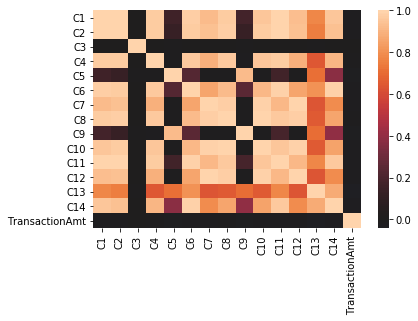

In [12]:
Cs_transaction = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'TransactionAmt']
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
c_train = data_trainTR[Cs_transaction]
c_test = data_testTR[Cs_transaction]

#ax, _ = plt.subplots(figsize=(13, 13))
sns.heatmap(c_train.corr(), center=0)

for c in Cs_transaction[:-1]:
  print(f'\n{c} orig.')
  c_train[c] = c_train[c].fillna(-999)
  c_test[c] = c_test[c].fillna(-999)
  str_info(c_train[c], c_test[c], data_trainTR['isFraud'])

  print(f'{c} + groupby TransactionAmt diviation')
  c_train[c + '_trans_div'] = c_train.groupby([c])['TransactionAmt'].transform('median') - c_train['TransactionAmt']
  c_test[c + '_trans_div'] = c_test.groupby([c])['TransactionAmt'].transform('median') - c_test['TransactionAmt']
  str_info(c_train[c + '_trans_div'], c_test[c + '_trans_div'], data_trainTR['isFraud'])

  print(f'{c} + groupby transaction Amt diviation quantiles')
  c_train[c + '_trans_div_q'] = pd.qcut(c_train[c + '_trans_div'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
  c_test[c + '_trans_div_q'] = pd.qcut(c_test[c + '_trans_div'], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], labels=False).fillna(-1)
  str_info(c_train[c + '_trans_div_q'], c_test[c + '_trans_div_q'], data_trainTR['isFraud'])

del c_train, c_test, Cs_transaction
gc.collect()

In [71]:
# features iteraction(with frequency encoding)
features = ['TransactionAmt', 'card1', 'card2', 'card3', 'card4', 'card5', 'card5', 'D15', 'C13', 'addr1', 'dist1', 'R_emaildomain']
train_iter = data_trainTR[features + ['isFraud']]
test_iter = data_testTR[features]
features_combinations = list(itertools.combinations(features, 2))

#mapping Remail
def pemail_map(email):
  mapping= {'frontier.com':'frontier','frontiernet.net':'frontier','gmail':'gmail','gmail.com':'gmail','hotmail.co.uk':'hotmail','hotmail.com':'Microsoft','hotmail.de':'Microsoft',
            'hotmail.es':'Microsoft','hotmail.fr':'Microsoft','icloud.com':'Apple','live.com':'Microsoft','live.com.mx':'Microsoft','live.fr':'Microsoft','mac.com':'Apple',
            'netzero.com':'Netzero','netzero.net':'Netzero','outlook.com':'Microsoft','outlook.es':'Microsoft', 'yahoo.co.jp':'Yahoo','yahoo.co.uk':'Yahoo','yahoo.com':'Yahoo',
            'yahoo.com.mx':'Yahoo','yahoo.de':'Yahoo','yahoo.es':'Yahoo','yahoo.fr':'Yahoo','ymail.com':'Yahoo', 'scranton.edu':'Scranton'}
  if email in mapping.keys():
    return mapping[email]
  elif pd.isnull(email):
    return 'NAN'
  else:
    return 'other'
train_iter['R_emaildomain'] = train_iter['R_emaildomain'].map(pemail_map)
test_iter['R_emaildomain'] = test_iter['R_emaildomain'].map(pemail_map)

for f1, f2 in features_combinations:
    feature_name = f1 + '_' + f2
    train_iter[feature_name] = train_iter[f1].astype('str') + '_' + train_iter[f2].astype('str')
    train_iter[feature_name] = train_iter[feature_name].map(train_iter[feature_name].value_counts())
    test_iter[feature_name] = test_iter[f1].astype('str') + '_' + test_iter[f2].astype('str')
    test_iter[feature_name] = test_iter[feature_name].map(test_iter[feature_name].value_counts())

    print(f"\n{feature_name}, frequency")
    str_info(train_iter[feature_name], test_iter[feature_name], data_trainTR['isFraud'])


 TransactionAmt_card1
//////////////////////////////
covariate:  0.5905281539504138
timeseries score:  0.5618365173913


KeyboardInterrupt: ignored

['2', '1', '2']

#                    EDA for original features

In [0]:
##transaction and id's datasets
data_TR = data_trainTR.copy()

quantiles = [0.05, 0.1, 0.15, 0.25, 0.5, 0.65, 0.8, 0.95, 0.97, 0.99]
data_ID_f = pd.concat([data_TR[data_TR['TransactionID'].isin(data_trainID['TransactionID'])]['isFraud'].reset_index(drop=True), 
           data_trainID], axis=1)

TransactionAmt : 0.0% nan's contain fraud
TransactionAmt quantiles:  [20.0, 25.95, 30.95, 43.321000000000005, 68.769, 107.95, 159.95, 445.0, 554.0, 1104.0]


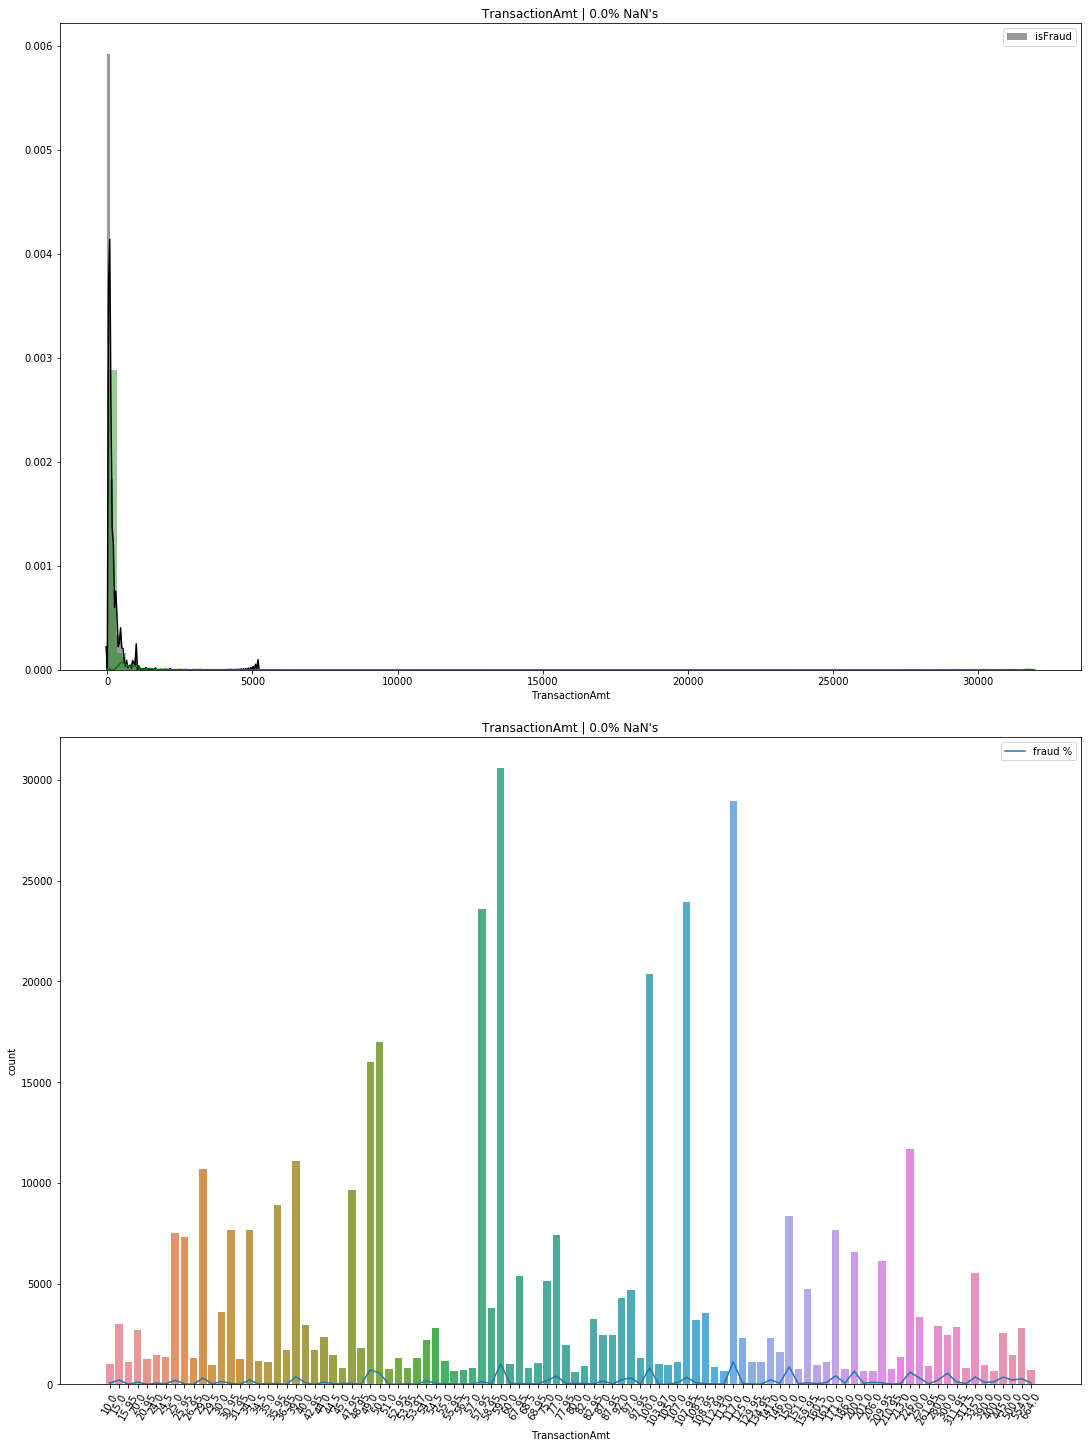

In [0]:
##########TransactionAmt##########
fg, axs = plt.subplots(ncols=1, nrows=2, figsize=(15, 20), constrained_layout=True)
axs = axs.flatten()

improved_distplot('TransactionAmt', data_TR, axs[0], 100)
top_values_hist('TransactionAmt', data_TR, axs[1], 100)
frauds_contains_in_nans('TransactionAmt', data_TR)
write_quantiles('TransactionAmt', data_TR, quantiles)

card2 : 0.02047% nan's contain fraud
card3 : 0.00189% nan's contain fraud
card3 quantiles:  [150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 185.0, 185.0, 185.0]
card5 : 0.01016% nan's contain fraud
card5 quantiles:  [102.0, 126.0, 138.0, 166.0, 226.0, 226.0, 226.0, 226.0, 226.0, 226.0]
card4 : 0.00198% nan's contain fraud
card6 : 0.00189% nan's contain fraud


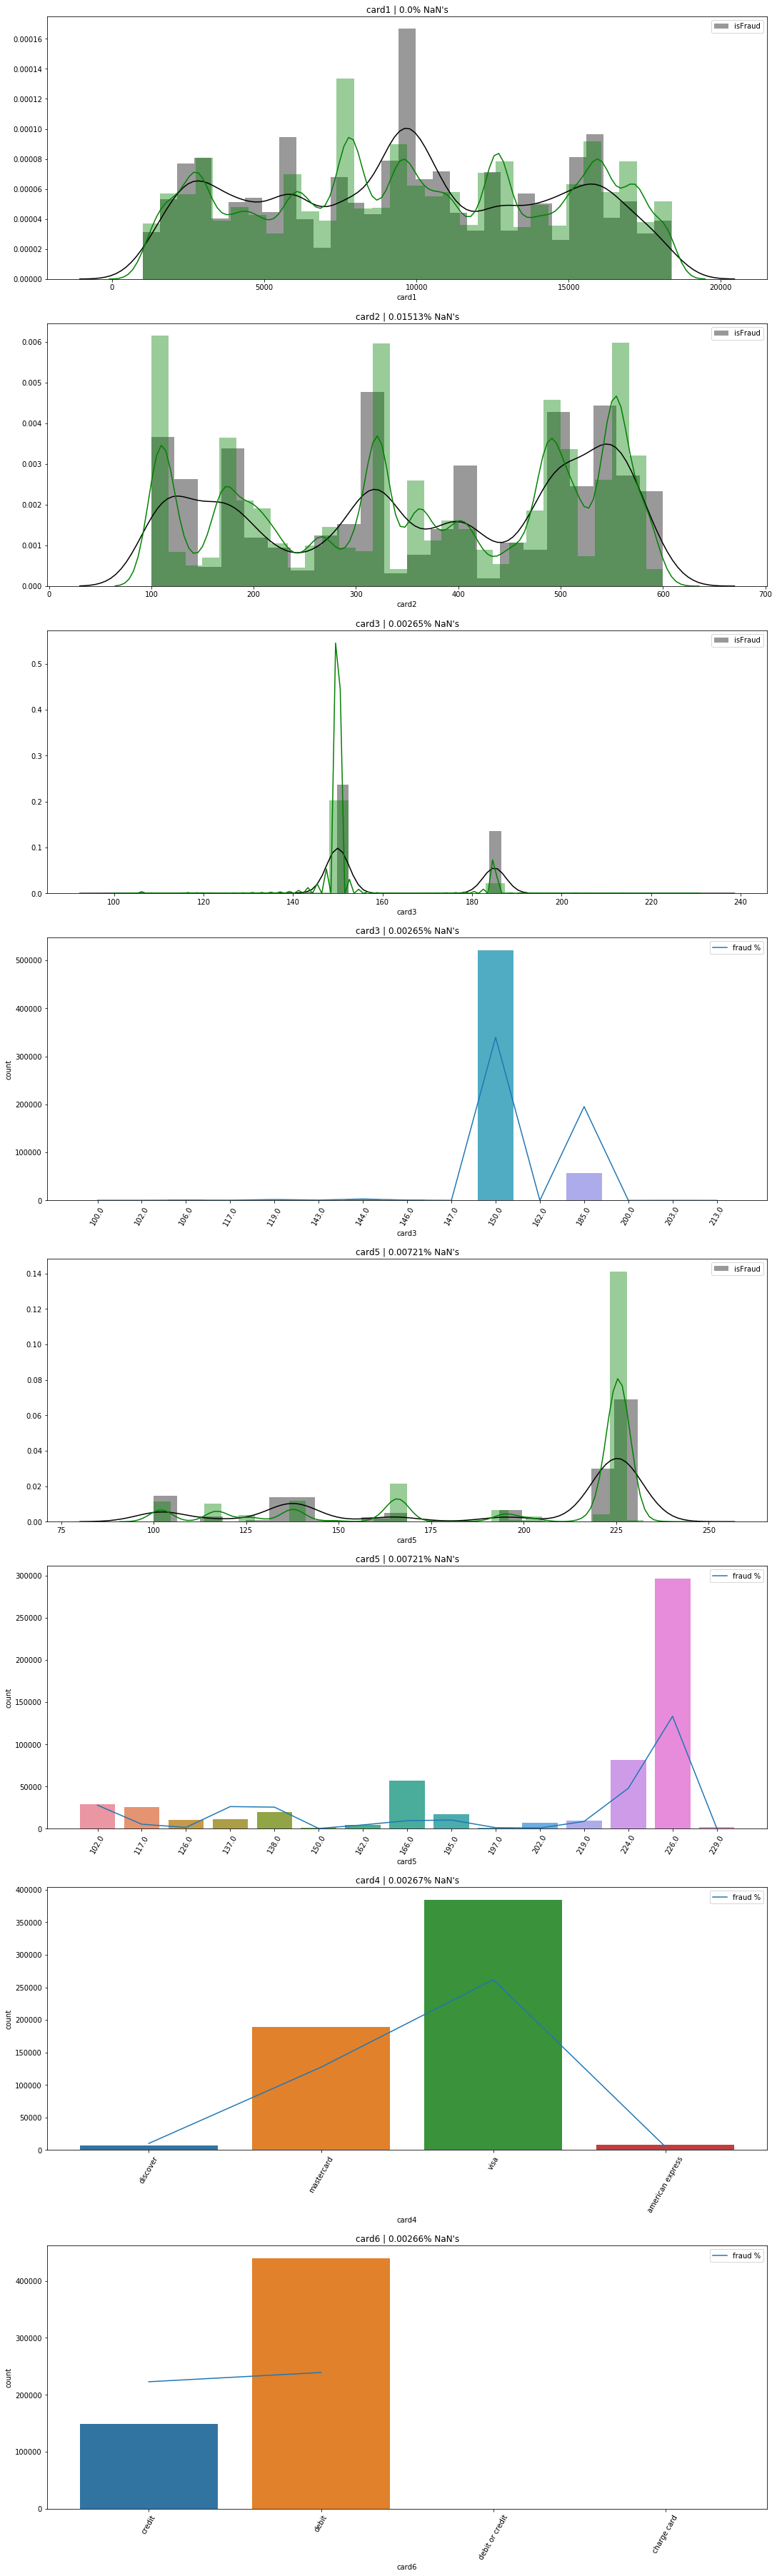

In [0]:
##########cards##########
fg, axs = plt.subplots(ncols=1, nrows=8, figsize=(15, 50), constrained_layout=True)
axs = axs.flatten()
quantiles = [0.05, 0.1, 0.15, 0.25, 0.5, 0.65, 0.8, 0.95, 0.97, 0.99]

#card1
improved_distplot('card1', data_TR, axs[0])

#card2
improved_distplot('card2', data_TR, axs[1])
frauds_contains_in_nans('card2', data_TR)

#card3
improved_distplot('card3', data_TR, axs[2])
top_values_hist('card3', data_TR, axs[3], 15)
frauds_contains_in_nans('card3', data_TR)
write_quantiles('card3', data_TR, quantiles)

#card5
improved_distplot('card5', data_TR, axs[4])
top_values_hist('card5', data_TR, axs[5], 15)
frauds_contains_in_nans('card5', data_TR)
write_quantiles('card5', data_TR, quantiles)

#card4
cat_hist('card4', data_TR, axs[6])
frauds_contains_in_nans('card4', data_TR)

#card6
cat_hist('card6', data_TR, axs[7])
frauds_contains_in_nans('card6', data_TR)

addr1 quantiles:  [126.0, 177.0, 184.0, 204.0, 299.0, 325.0, 337.0, 485.0, 494.0, 512.0]
addr1 : 0.37463% nan's contain fraud
addr2 quantiles:  [87.0, 87.0, 87.0, 87.0, 87.0, 87.0, 87.0, 87.0, 87.0, 87.0]
addr2 : 0.37463% nan's contain fraud


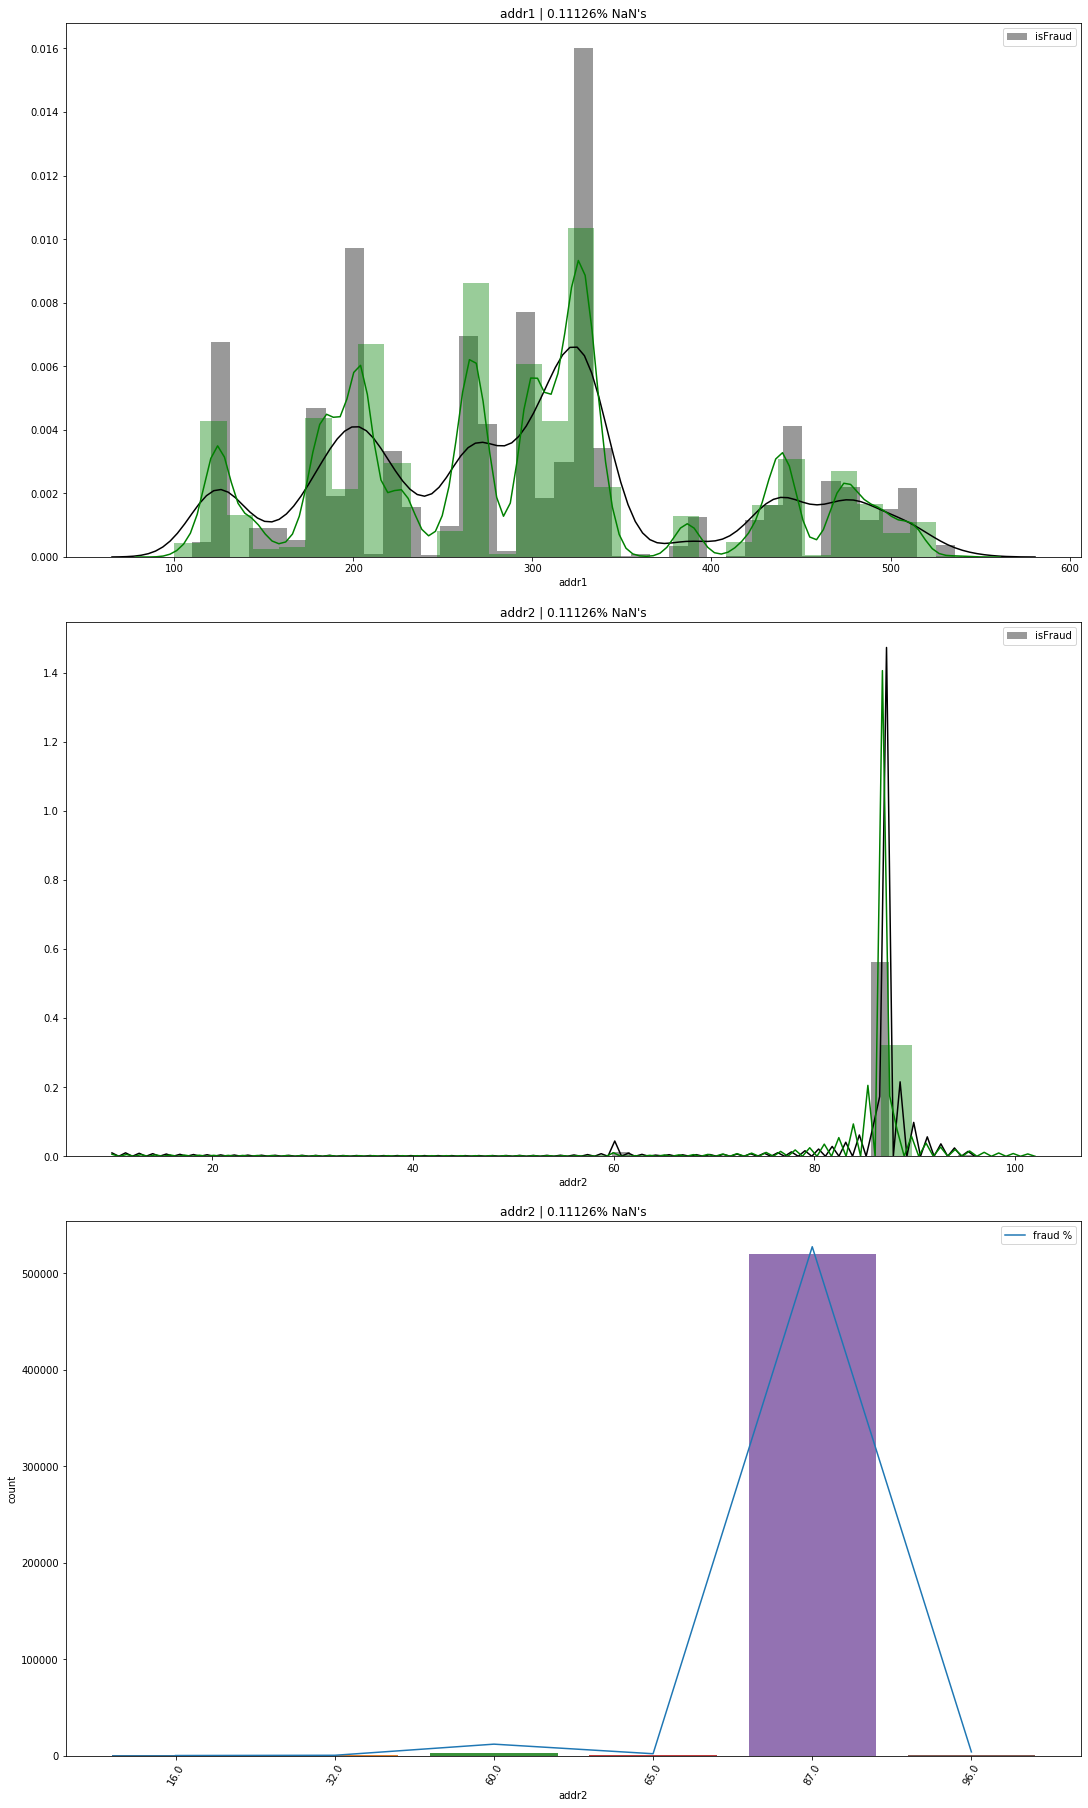

In [0]:
##########addrs##########
fg, axs = plt.subplots(ncols=1, nrows=3, figsize=(15, 25), constrained_layout=True)
axs = axs.flatten()

#addr1
improved_distplot('addr1', data_TR, axs[0])
write_quantiles('addr1', data_TR, quantiles)
frauds_contains_in_nans('addr1', data_TR)

#addr2
improved_distplot('addr2', data_TR, axs[1])
top_values_hist('addr2', data_TR, axs[2], 6)
write_quantiles('addr2', data_TR, quantiles)
frauds_contains_in_nans('addr2', data_TR)

dist1 : 0.76988% nan's contain fraud
dist1 quantiles:  [0.0, 1.0, 1.0, 3.0, 8.0, 15.0, 36.0, 846.0, 1133.0, 2040.0]
dist1 LOG quantiles:  [0.69314718 1.09861229 1.09861229 1.60943791 2.30258509 2.83321334
 3.63758616 6.74288064 7.03438793 7.621685  ]
dist2 : 0.81944% nan's contain fraud
dist2 quantiles:  [0.0, 1.0, 3.0, 7.0, 37.0, 131.0, 306.8000000000029, 1001.0, 1625.8800000000047, 2367.479999999996]
dist2 LOG quantiles:  [0.69314718 1.09861229 1.60943791 2.19722458 3.66356165 4.89034913
 5.73269298 6.91075079 7.39503332 7.77042573]


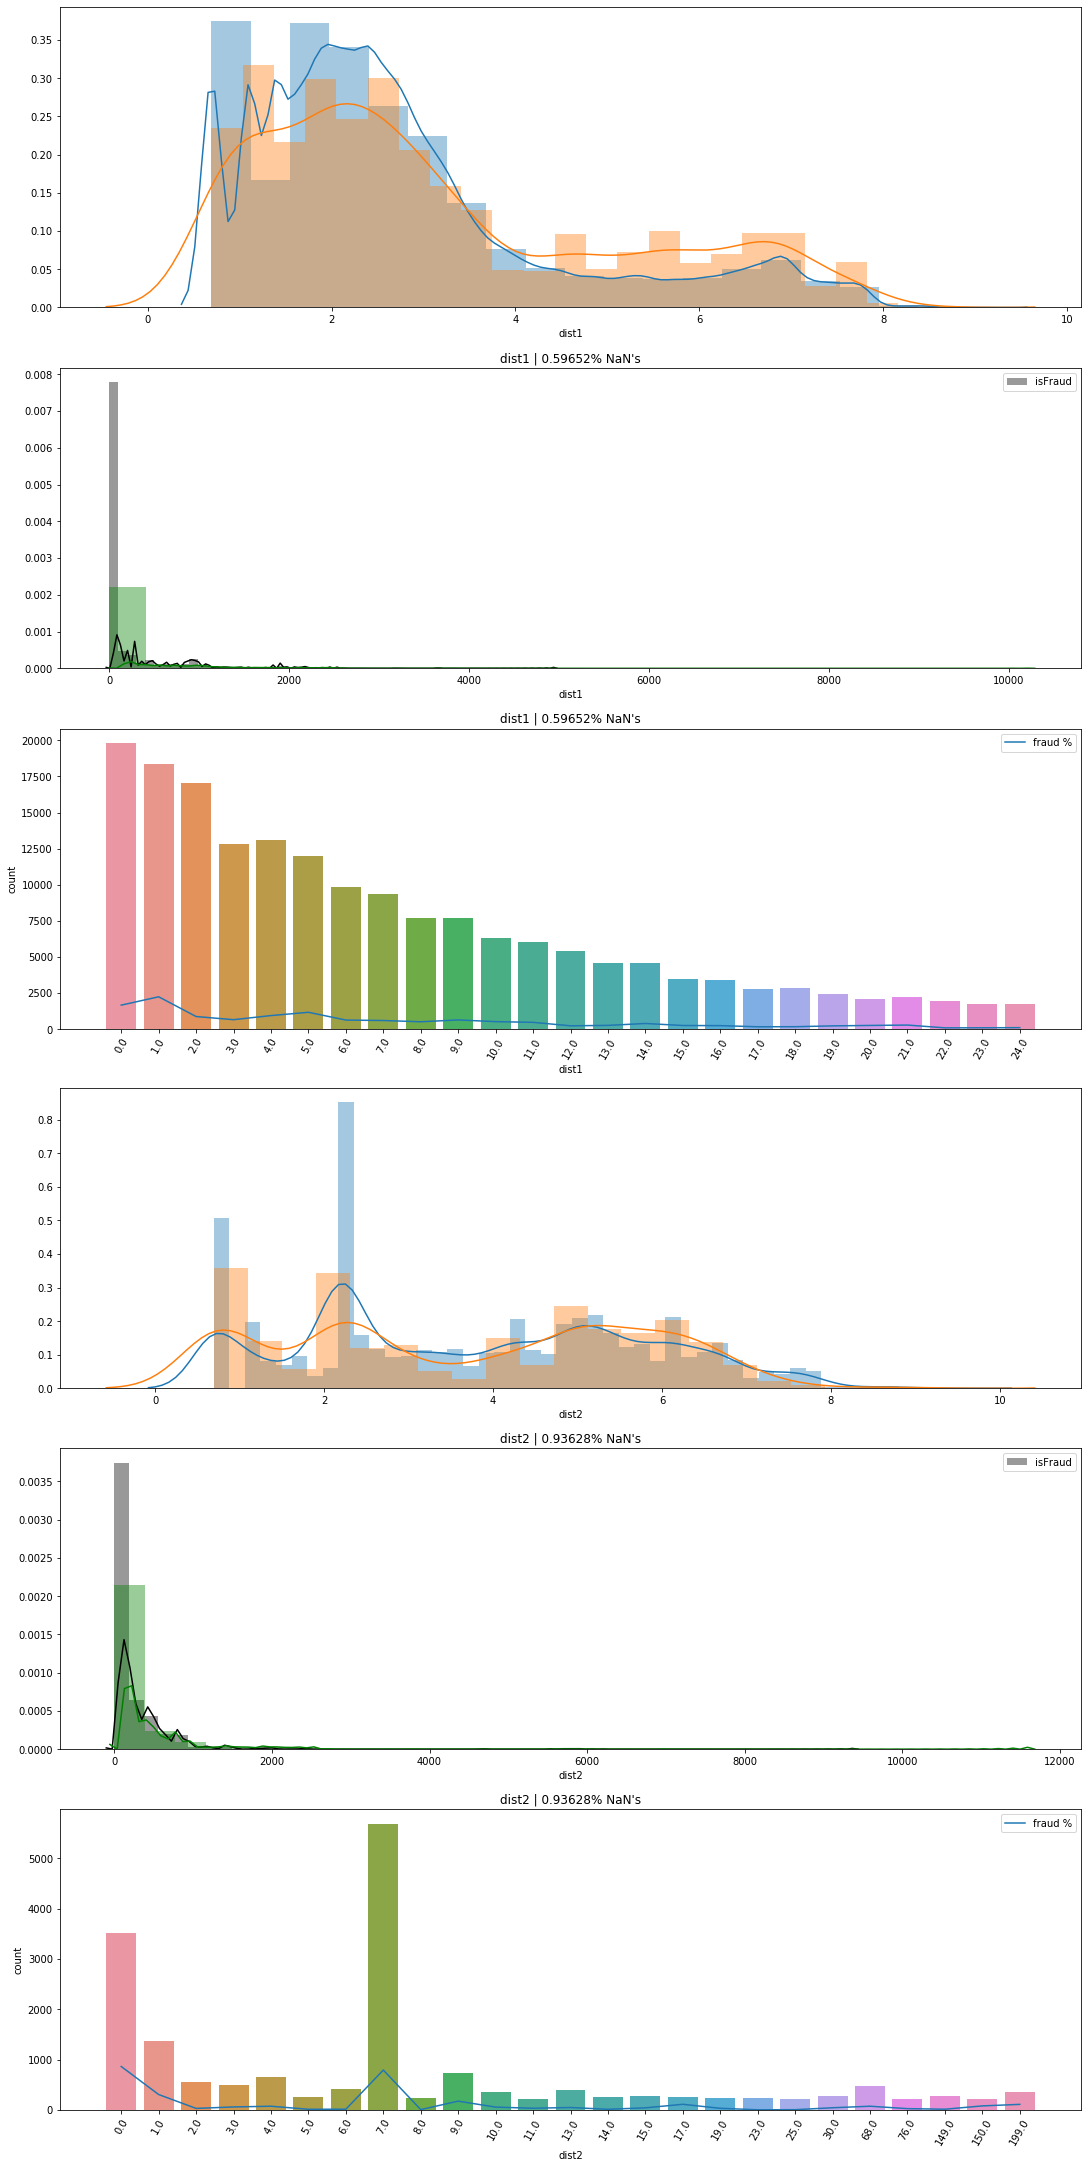

In [0]:
##########dists##########
fg, axs = plt.subplots(ncols=1, nrows=6, figsize=(15, 30), constrained_layout=True)
axs = axs.flatten()

#dist1
sns.distplot(np.log(data_TR['dist1'] + 2).dropna(), ax=axs[0], bins=20)
sns.distplot(np.log(data_TR[data_TR['isFraud'] == 1]['dist1'] + 2).dropna(), ax=axs[0])
improved_distplot('dist1', data_TR, axs[1], 25)
top_values_hist('dist1', data_TR, axs[2], 25)
frauds_contains_in_nans('dist1', data_TR)
write_quantiles('dist1', data_TR, quantiles)
print('dist1 LOG quantiles: ',
      np.quantile(np.log(data_TR['dist1'] + 2).dropna(), quantiles))

#dist2
sns.distplot(np.log(data_TR['dist2'] + 2).dropna(), ax=axs[3])
sns.distplot(np.log(data_TR[data_TR['isFraud'] == 1]['dist2'] + 2).dropna(), ax=axs[3])
improved_distplot('dist2', data_TR, axs[4])
top_values_hist('dist2', data_TR, axs[5], 25)
frauds_contains_in_nans('dist2', data_TR)
write_quantiles('dist2', data_TR, quantiles)
print('dist2 LOG quantiles: ',
      np.quantile(np.log((data_TR['dist2'] + 2).dropna()), quantiles))

P_emaildomain : 0.13502% nan's contain fraud
R_emaildomain : 0.45666% nan's contain fraud


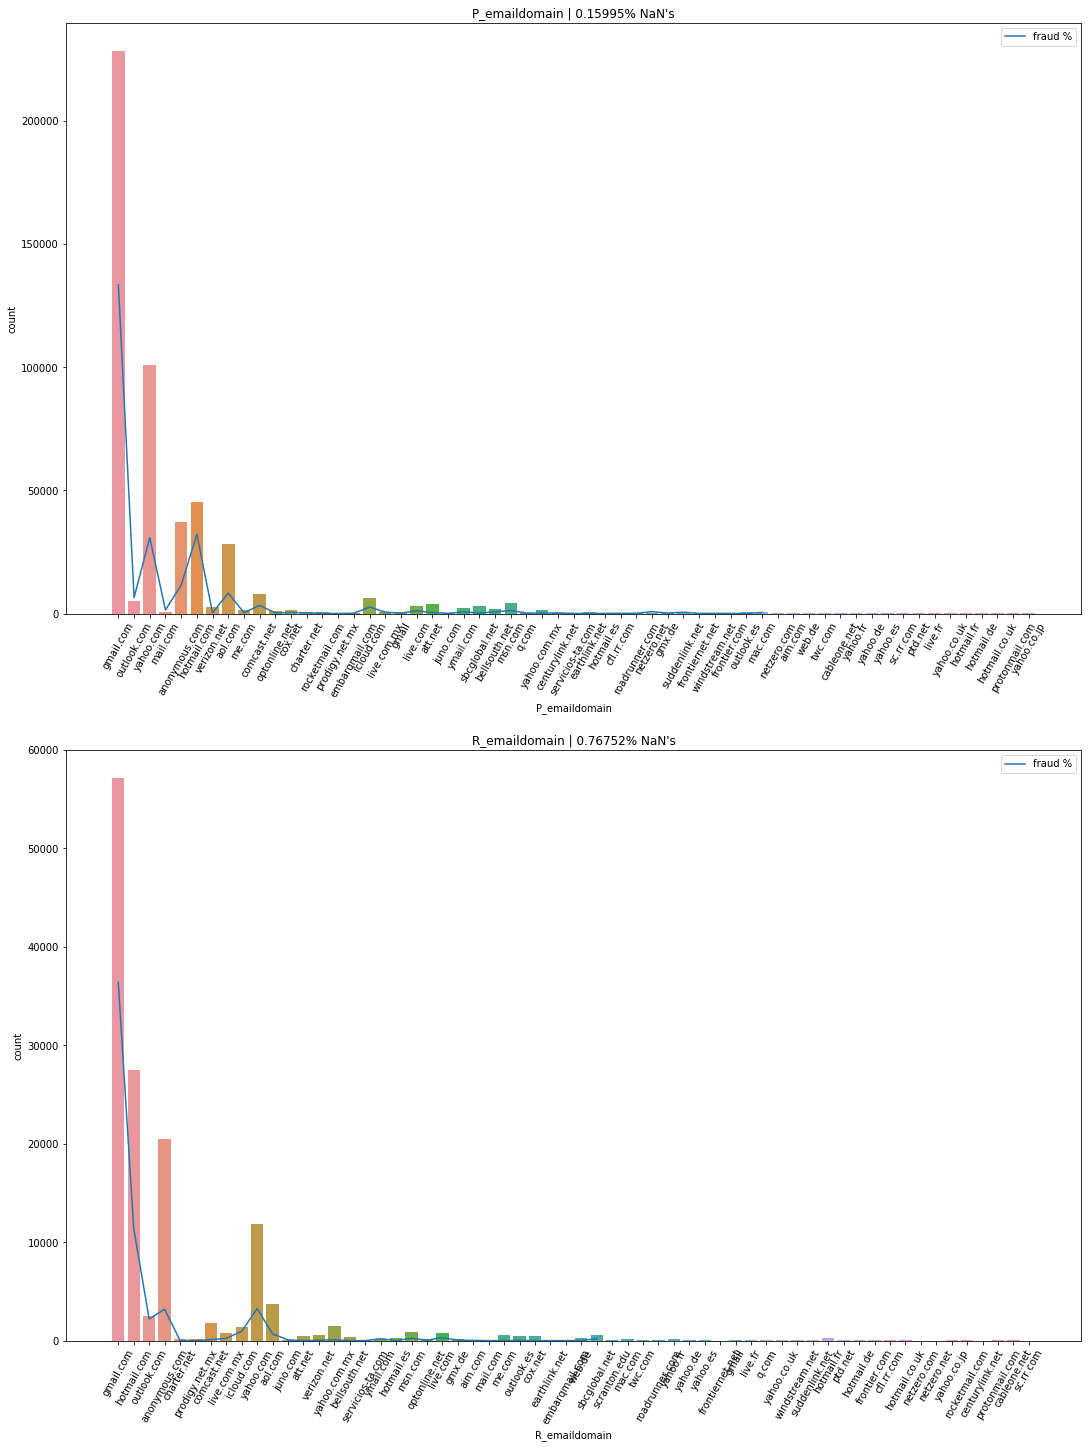

In [0]:
##########P_emaildomain##########
fg, axs = plt.subplots(ncols=1, nrows=2, figsize=(15, 20), constrained_layout=True)
axs = axs.flatten()

#P_emaildomain
cat_hist('P_emaildomain', data_TR, ax=axs[0])
frauds_contains_in_nans('P_emaildomain', data_TR)

#R_emaildomain
cat_hist('R_emaildomain', data_TR, ax=axs[1])
frauds_contains_in_nans('R_emaildomain', data_TR)

C1 quantiles:  [1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 3.0, 22.0, 110.0, 164.0]
C1 log+1 quantiles: [1.0986122886681098, 1.0986122886681098, 1.0986122886681098, 1.0986122886681098, 1.0986122886681098, 1.3862943611198906, 1.6094379124341005, 3.1780538303479458, 4.718498871295094, 5.111987788356544]
C2 quantiles:  [1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 4.0, 27.0, 101.0, 154.0]
C2 log+1 quantiles: [1.0986122886681098, 1.0986122886681098, 1.0986122886681098, 1.0986122886681098, 1.0986122886681098, 1.3862943611198906, 1.791759469228055, 3.367295829986474, 4.634728988229636, 5.049856007249537]
C3 quantiles:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
C3 log+1 quantiles: [0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599452, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453]
C4 quantiles:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 6.0]
C4 log+1 quantiles: [0.6931471805599453, 0.6931471805599453, 0.693147

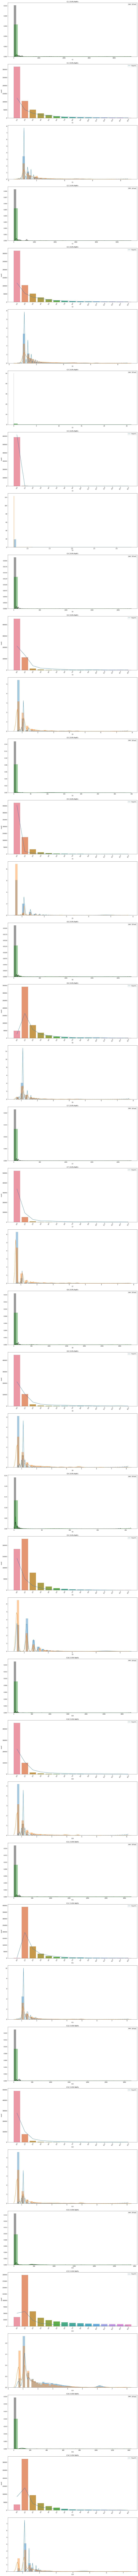

In [0]:
##########C##########
fg, axs = plt.subplots(ncols=1, nrows=42, figsize=(16, 300), constrained_layout=True)
axs = axs.flatten()

c = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
for ce, cn in zip(c, range(0, 3*len(c), 3)):
    improved_distplot(ce, data_TR, axs[cn])
    top_values_hist(ce, data_TR, axs[cn+1], 15)
    sns.distplot(np.log((data_TR[ce] + 2).dropna()), ax=axs[cn+2])
    sns.distplot(np.log((data_TR[data_TR['isFraud'] == 1][ce] + 2).dropna()), ax=axs[cn+2])
    write_quantiles(ce, data_TR, quantiles)
    print(f"{ce} log+1 quantiles: {list(np.log(data_TR[ce] + 2).quantile(quantiles))}")

D1 quantiles:  [0.0, 0.0, 0.0, 0.0, 3.0, 51.0, 179.0, 489.0, 536.0, 602.0]
D1 : 0.00223% nan's contain fraud
D2 quantiles:  [1.0, 4.0, 9.0, 26.0, 97.0, 185.0, 336.0, 540.0, 575.0, 617.0]
D2 : 0.61913% nan's contain fraud
D3 quantiles:  [0.0, 0.0, 0.0, 1.0, 8.0, 16.0, 31.0, 129.0, 198.0, 356.0]
D3 : 0.53448% nan's contain fraud
D4 quantiles:  [0.0, 0.0, 0.0, 0.0, 26.0, 123.0, 333.0, 544.0, 577.0, 623.0]
D4 : 0.29502% nan's contain fraud
D5 quantiles:  [0.0, 0.0, 0.0, 1.0, 10.0, 21.0, 45.0, 246.0, 337.0, 455.0]
D5 : 0.47345% nan's contain fraud
D6 quantiles:  [0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 105.0, 405.0, 461.0, 593.0]
D6 : 0.62648% nan's contain fraud
D7 quantiles:  [0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 34.0, 321.0, 365.0, 429.0]
D7 : 0.71979% nan's contain fraud
D8 quantiles:  [0.125, 0.5833330154418945, 0.75, 0.9583330154418944, 37.875, 110.125, 241.625, 738.6562652587891, 861.625, 983.9270629882812]
D8 : 0.62121% nan's contain fraud
D9 quantiles:  [0.0, 0.04166600108146668, 0.0833330005407333

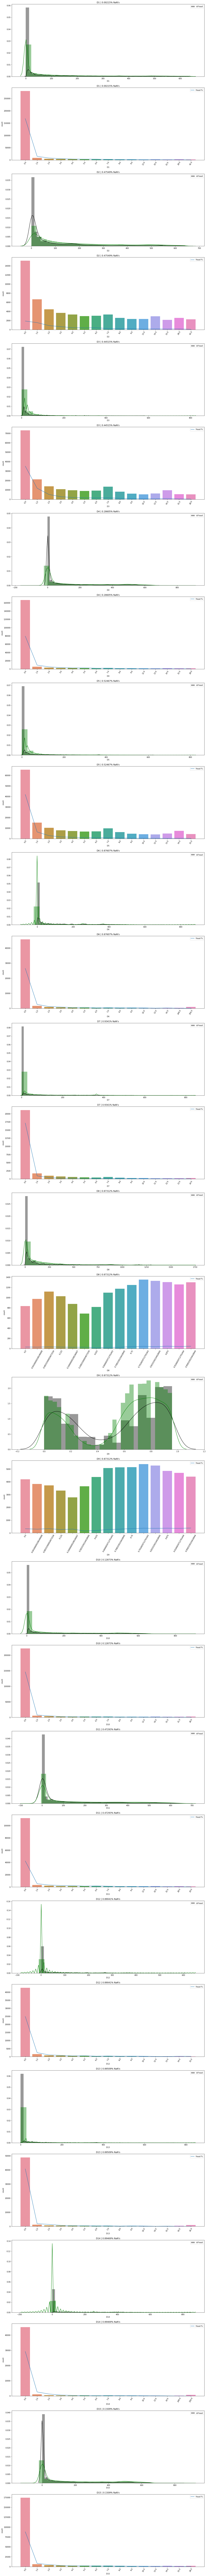

In [0]:
##########D##########
fg, axs = plt.subplots(ncols=1, nrows=30, figsize=(16, 200), constrained_layout=True)
axs = axs.flatten()

d = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']
for de, dn in zip(d, range(0, 2*len(d), 2)):
    improved_distplot(de, data_TR, axs[dn])
    top_values_hist(de, data_TR, axs[dn+1], 15)
    write_quantiles(de, data_TR, quantiles)
    frauds_contains_in_nans(de, data_TR)

M1 : 0.69307% nan's contain fraud
M2 : 0.69307% nan's contain fraud
M3 : 0.69307% nan's contain fraud
M4 : 0.25296% nan's contain fraud
M5 : 0.63369% nan's contain fraud
M6 : 0.57934% nan's contain fraud
M7 : 0.76688% nan's contain fraud
M8 : 0.76688% nan's contain fraud
M9 : 0.76688% nan's contain fraud


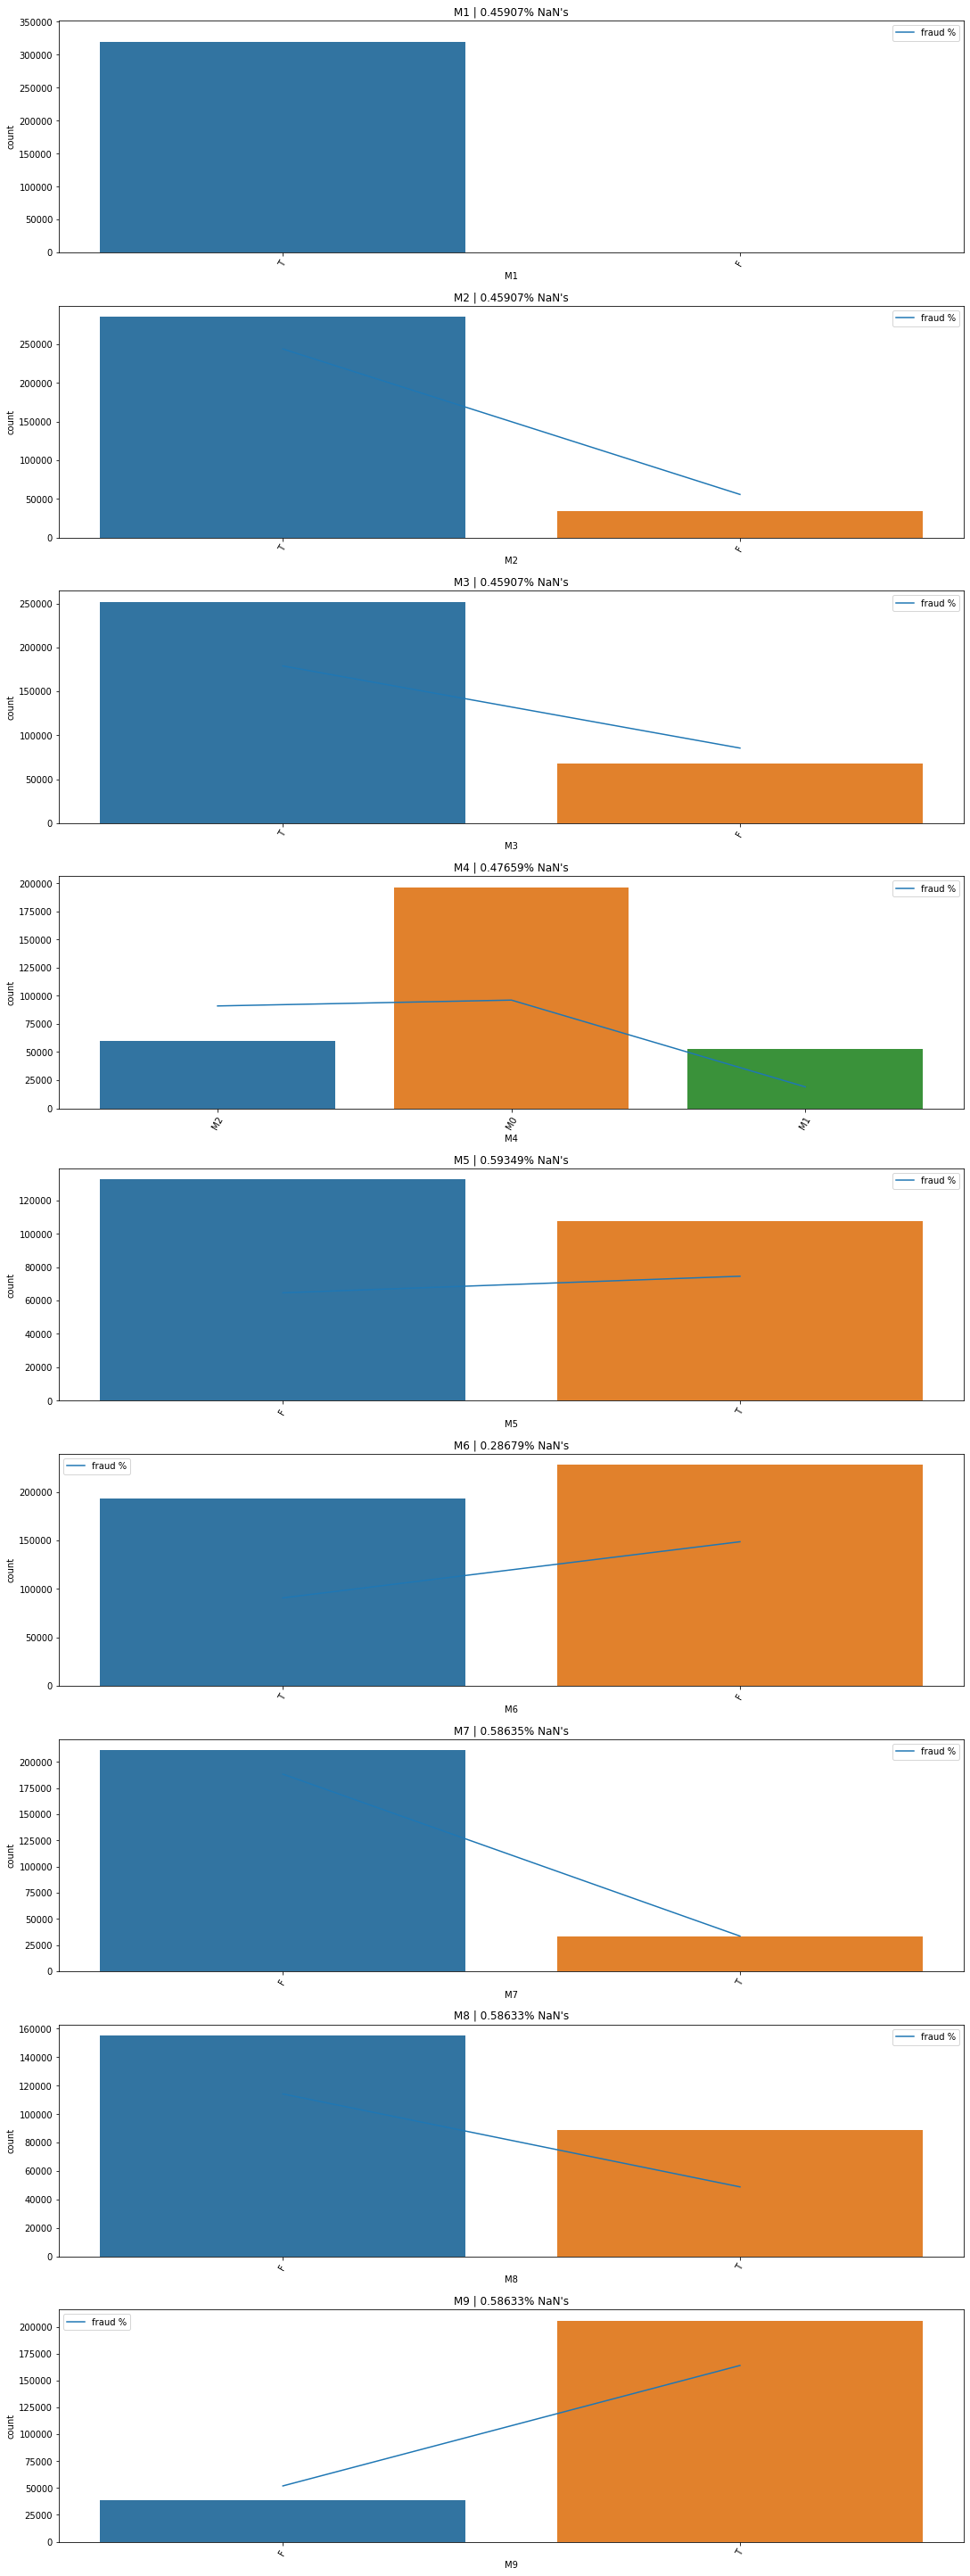

In [0]:
##########M##########
fg, axs = plt.subplots(ncols=1, nrows=9, figsize=(15, 40), constrained_layout=True)
axs = axs.flatten()

m = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
for me, ax in zip(m, axs):
    cat_hist(me, data_TR, ax)
    frauds_contains_in_nans(me, data_TR)

ProductCD : 0.0% nan's contain fraud


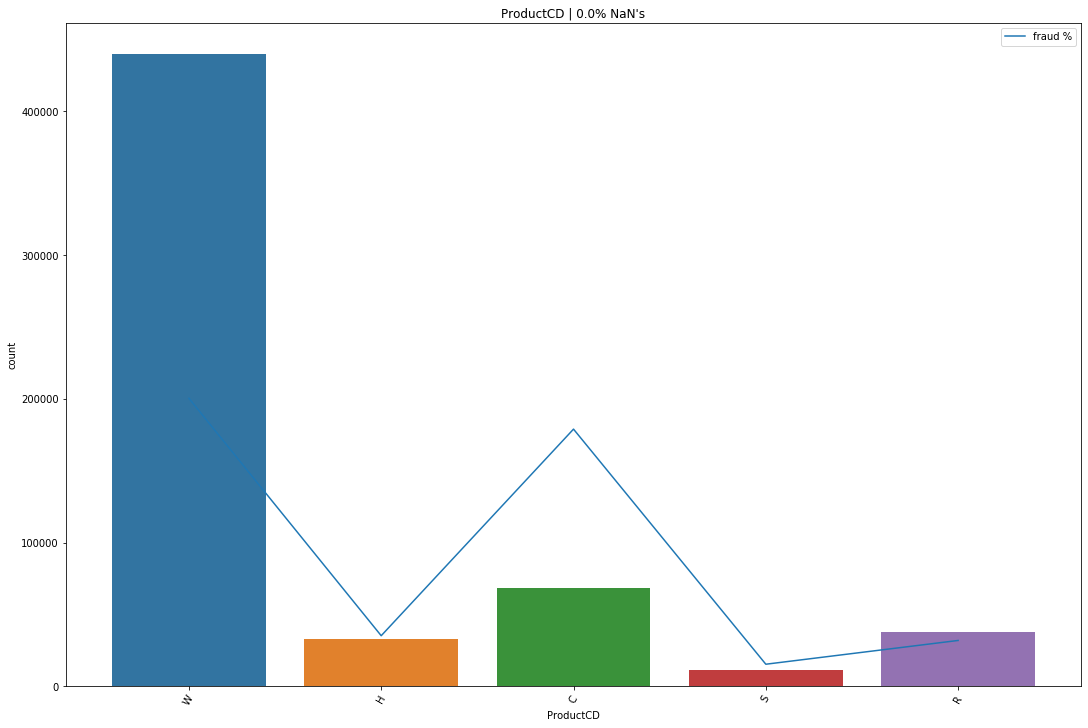

In [0]:
##########Product_CD##########
fg, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 10), constrained_layout=True)

cat_hist('ProductCD', data_TR, ax)
frauds_contains_in_nans('ProductCD', data_TR)

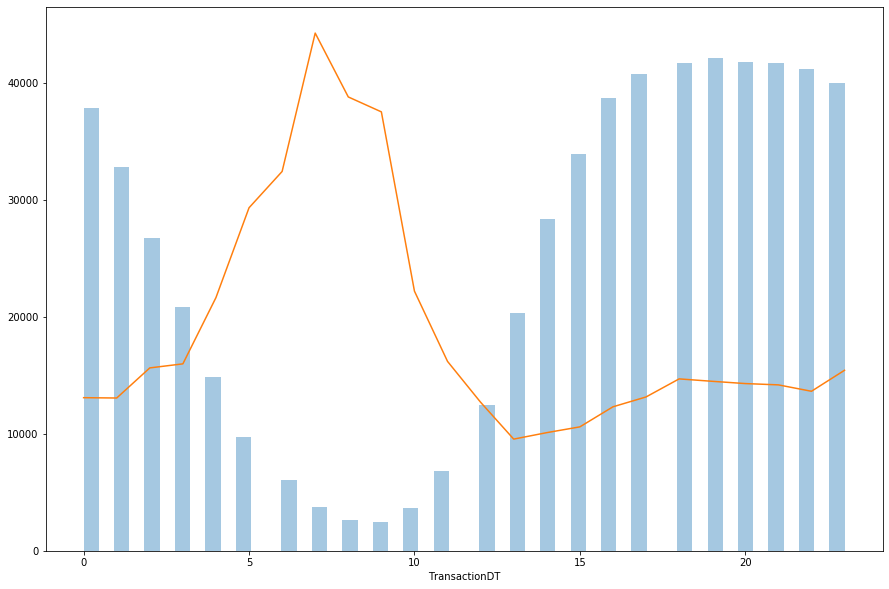

In [0]:
##########TransactionDT##########
fg, ax = plt.subplots(figsize=(15, 10))
test = pd.concat([((data_TR['TransactionDT'] % 86400) // 3600), data_TR['isFraud']], axis=1)
sns.distplot(test['TransactionDT'], ax=ax, kde=False)

labelsx = list(test['TransactionDT'].unique())
labelsx.sort()
fraudsx = [(test[test['TransactionDT'] == x]['isFraud'] == 1).sum()/(test['TransactionDT'] == x).sum() for x in labelsx]
fs = [(ax.get_ylim()[1] * f)/max(fraudsx) for f in fraudsx]

plt.plot(labelsx, fs)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars


id_01 quantiles:  [-40.0, -20.0, -20.0, -10.0, -5.0, -5.0, -5.0, 0.0, 0.0, 0.0]
id_01 : nan% nan's contain fraud
id_02 quantiles:  [11475.2, 30762.0, 44607.649999999994, 67992.0, 125800.5, 177044.6500000001, 265238.80000000005, 511458.6999999999, 596690.5099999997, 770898.3200000001]
id_02 : nan% nan's contain fraud
id_03 quantiles:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0]
id_03 : nan% nan's contain fraud
id_04 quantiles:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
id_04 : nan% nan's contain fraud
id_05 quantiles:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 12.0, 16.0, 25.0]
id_05 : nan% nan's contain fraud
id_06 quantiles:  [-33.0, -24.0, -12.0, -6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
id_06 : nan% nan's contain fraud
id_07 quantiles:  [-3.0, 0.0, 1.0, 5.0, 14.0, 17.0, 24.0, 31.0, 34.0, 39.0]
id_07 : nan% nan's contain fraud
id_08 quantiles:  [-100.0, -91.20000000000005, -57.0, -48.0, -34.0, -28.0, -19.0, 0.0, 0.0, 0.0]
id_08 : nan% nan's contain fraud
id_09 quantiles:  [0.0, 0

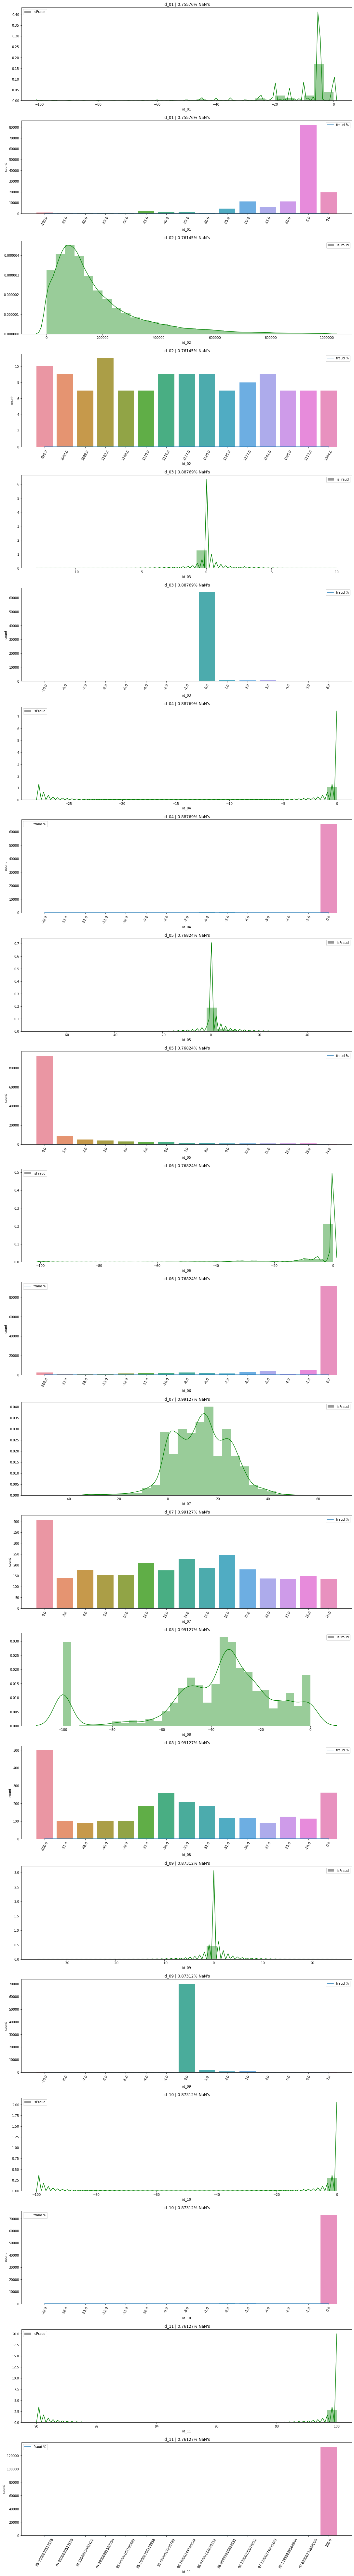

In [0]:
##########ID1-11##########
fg, axs = plt.subplots(nrows=22, ncols=1, figsize=(15, 110), constrained_layout=True)
axs = axs.flatten()
id1_11 = ['id_01','id_02','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10','id_11']


for ids, idn in zip(id1_11, range(0, 2*len(id1_11), 2)):
    improved_distplot(ids, data_ID_f, axs[idn])
    write_quantiles(ids, data_ID_f, quantiles)
    frauds_contains_in_nans(ids, data_ID_f)
    top_values_hist(ids, data_ID_f, axs[idn+1], 15)

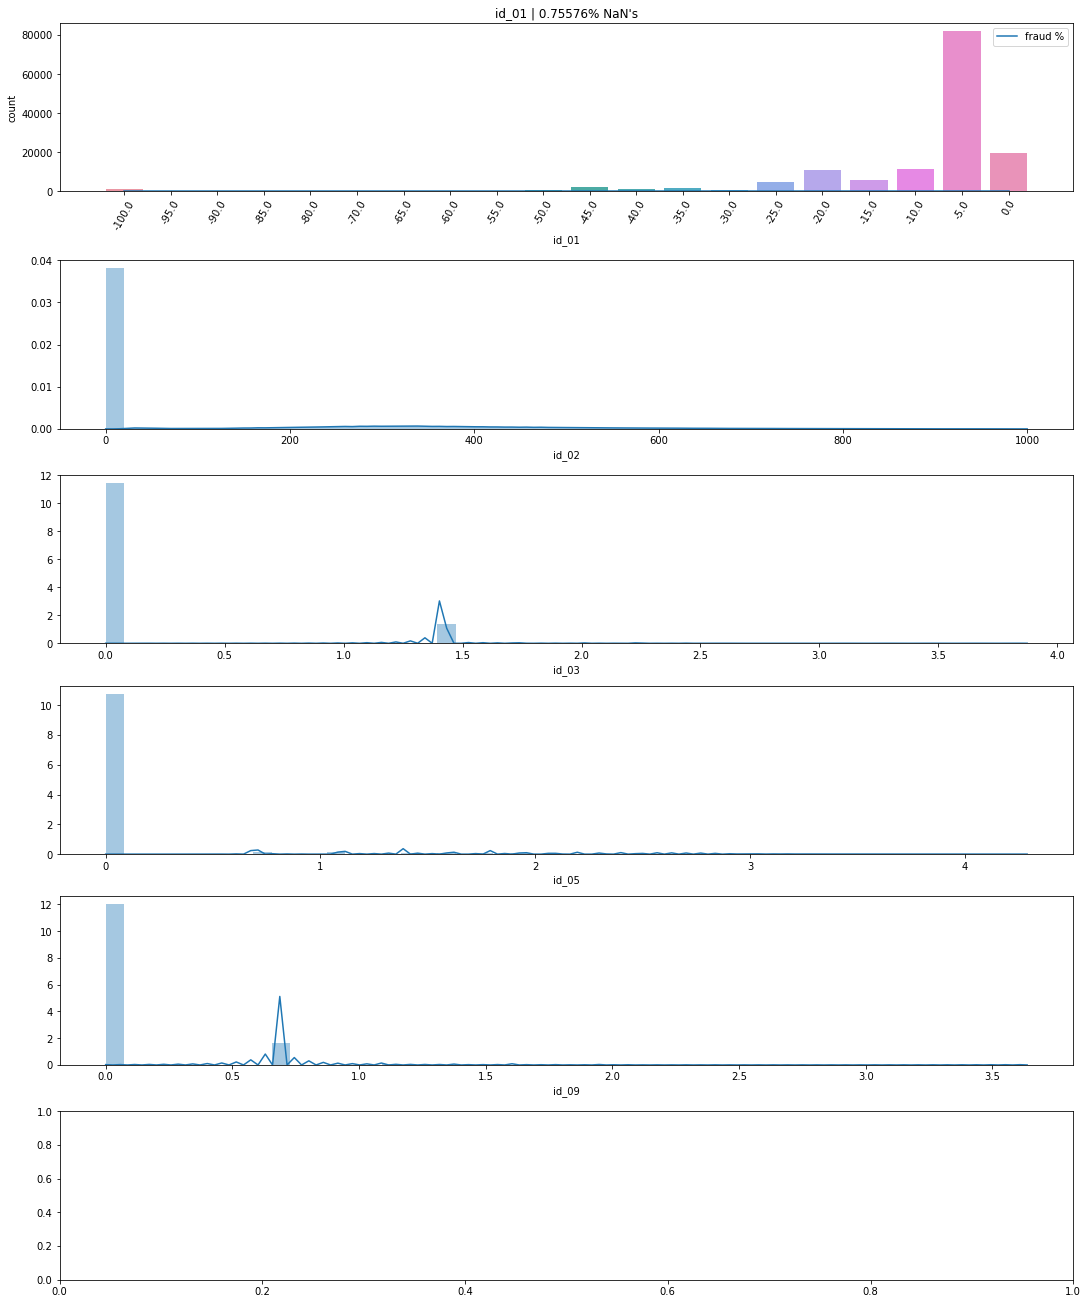

In [0]:
###TEST, add new features for normal distribution
fg, axs = plt.subplots(ncols=1, nrows=6, figsize=(15, 18), constrained_layout=True)
axs = axs.flatten()

top_values_hist('id_01', data_ID_f, ax=axs[0], top_values_number=20)
sns.distplot(np.sqrt(data_ID_f['id_02']).fillna(0), ax=axs[1])
sns.distplot(np.sqrt(np.abs(data_ID_f['id_03']) + 2).fillna(0), ax=axs[2])
sns.distplot(np.log(np.abs(data_ID_f['id_05']) + 1).fillna(0), ax=axs[3])
sns.distplot(np.log(np.abs(data_ID_f['id_09']) + 2).fillna(0), ax=axs[4])

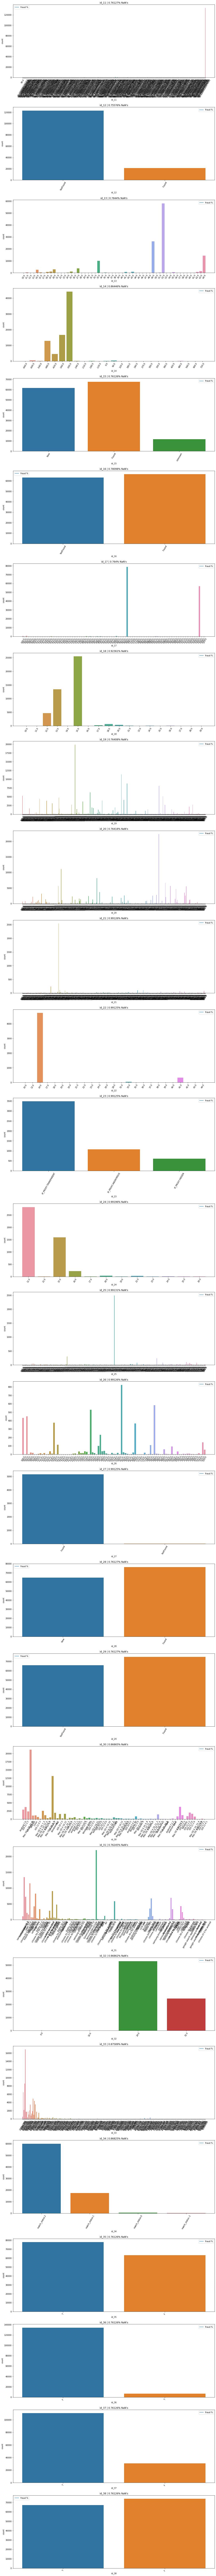

In [0]:
##########ID12-38##########
fg, axs = plt.subplots(ncols=1, nrows=28, figsize=(15, 180), constrained_layout=True)
axs = axs.flatten()
id12_38 = list(data_ID_f.columns)[13:41]

for ids, idn in zip(id12_38, range(0, len(id12_38))):
    cat_hist(ids, data_ID_f, axs[idn])

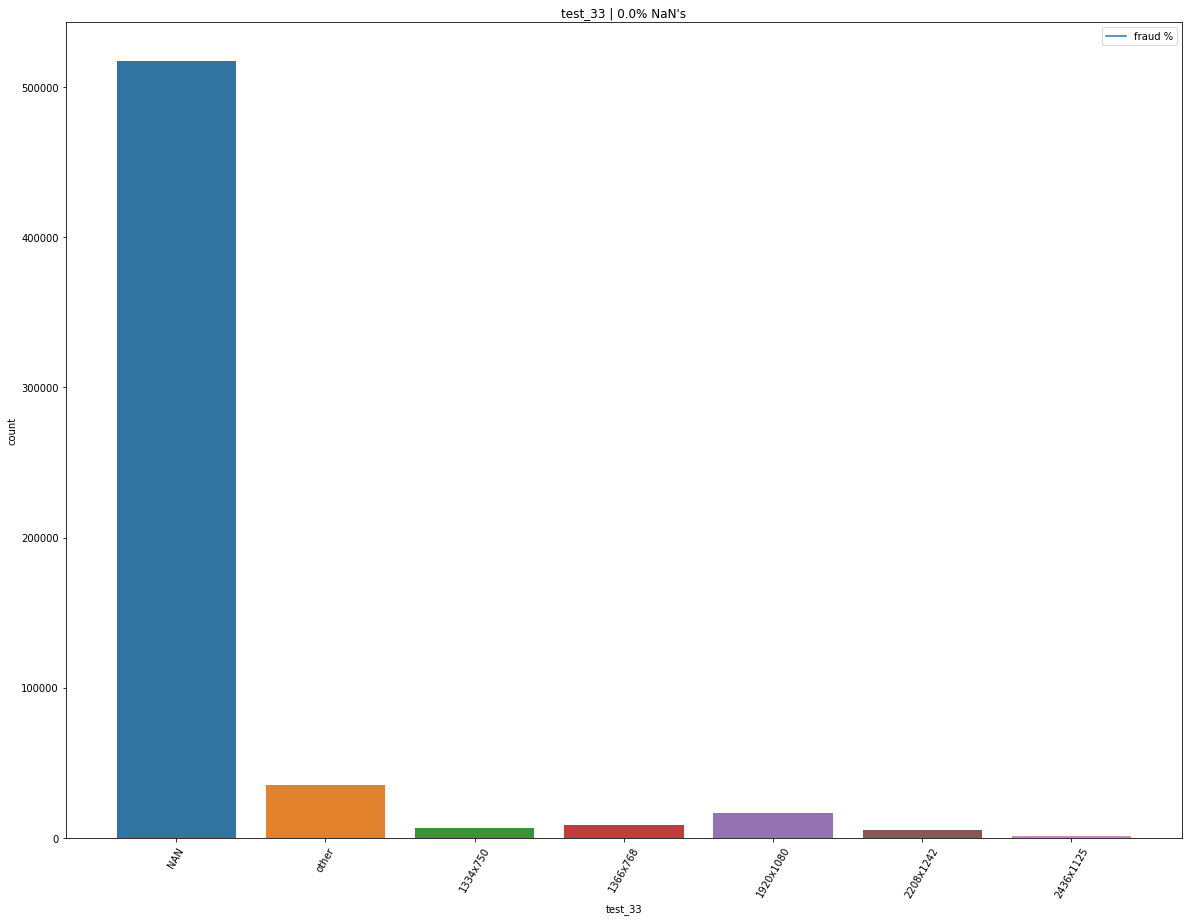

In [0]:
#ID33
fg, ax = plt.subplots(figsize=(20, 15))
def parse_33(x):
        devices_33_list = ['1334x750', '2436x1125', '1366x768', '1920x1080', '2208x1242']
        if pd.isnull(x):
            return 'NAN'
        if x in devices_33_list:
            return x
        else:
            return 'other'
        
data_ID_f['test_33'] = data_ID_f['id_33'].map(parse_33)
cat_hist('test_33', data_ID_f, ax)

In [0]:
##########DEVICETYPE and DEVICEINFO##########
fg, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 28))
axs = axs.flatten()
cat_hist('DeviceType', data_ID_f, axs[0])
frauds_contains_in_nans('DeviceType', data_ID_f)
cat_hist('DeviceInfo', data_ID_f.replace(list(data_ID_f['DeviceInfo'].value_counts().index)[20:],
                                                        'NAN'), axs[1])
frauds_contains_in_nans('DeviceInfo', data_ID_f)